# Avaliação 01 - CNN

- Base Escolhida: Intel Image Classification disponível no Kaggle https://www.kaggle.com/datasets/puneet6060/intel-image-classification
- Printar feature maps
- Interpretar perda
- Plotar imagens corretamente e incorretamente classificadas
- Experimento com valores normalizados

In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
import keras_tuner
from sklearn.model_selection import train_test_split
import keras

from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D


from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

import numpy as np
import random
import os
from PIL import Image
import pickle
from scipy.stats import kstest, friedmanchisquare, wilcoxon
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive/') # My Drive/Colab Notebooks
base_path = '/content/drive/My Drive/Colab Notebooks/'
# base_path = 'av01_cnn'

RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mounted at /content/drive/
Tue Oct 15 11:12:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   40C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+----------------------------------------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
categories = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}

## Carregar imagens e fazer o resize para que as dimensoes estejam batendo

In [5]:
def load_images_from_subfolders(parent_folder):
    image_data = []
    labels = []

    for folder_name in os.listdir(parent_folder):
        subfolder_path = os.path.join(parent_folder, folder_name)
        if os.path.isdir(subfolder_path):
            for image_file in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_file)

                try:
                    # Open image and convert to RGB (optional)
                    # img = Image.open(image_path).convert('RGB')
                    img = Image.open(image_path)
                    img = img.resize((150, 150))

                    img_array = np.array(img)

                    image_data.append(img_array)
                    labels.append(folder_name)
                except Exception as e:
                    print(f"Error loading image {image_file}: {e}")

    for index, image in enumerate(image_data):
        if image.shape != (150, 150, 3):
            print(image.shape)
            image_data.pop(index)
            labels.pop(index)
    image_data = np.array(image_data)
    labels = np.array(labels)

    if len(image_data) != len(labels):
        raise ValueError("Image Data and Labels are not the same length")
    return image_data, labels

def label_encode(label_array):
    for i in range(len(label_array)):
        label_array[i] = int(categories[label_array[i]])
    label_array = label_array.astype(int)
    print(label_array[:5])
    print(type(label_array[0]))
    print(label_array.shape)
    return label_array


In [6]:
# Example usage:
print(base_path + 'data2/seg_train/')
train_folder = base_path + 'data2/seg_train/'
train_image_data, train_labels = load_images_from_subfolders(train_folder)

# Check the shape of the first image array and its label
print(f"Shape of first image array: {train_image_data[0].shape}")
print(f"First image label: {train_labels[0]}")

/content/drive/My Drive/Colab Notebooks/data2/seg_train/
Shape of first image array: (150, 150, 3)
First image label: buildings


### Visualizando imagens

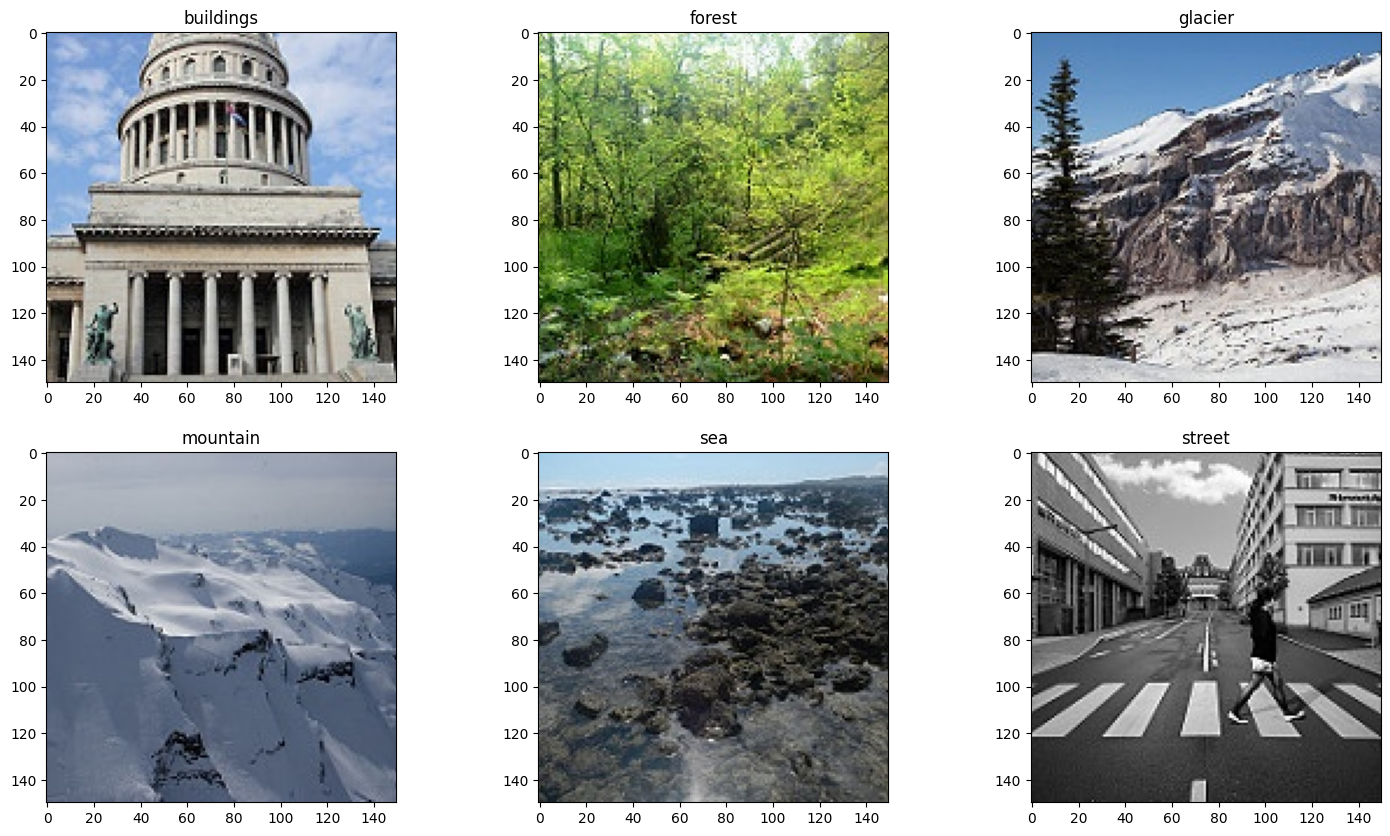

In [7]:
plt.figure(figsize=(18, 10))
for i in range(6):

    plt.subplot(2, 3, i+1)
    plt.axis(True)

    label = list(categories.keys())[list(categories.values()).index(i)]

    index = np.where(train_labels == label)[0][0]

    plt.imshow(train_image_data[index])
    plt.title(train_labels[index])
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

Encoding das labels para treinamento do modelo:

In [8]:
train_labels = label_encode(train_labels)

[0 0 0 0 0]
<class 'numpy.int64'>
(14034,)


In [9]:
print(train_image_data.shape)

(14034, 150, 150, 3)


### Carregando segundo batch; unindo todas as imagens em um vetor

In [10]:
test_folder = base_path + 'data2/seg_test/'
test_image_data, test_labels = load_images_from_subfolders(test_folder)
test_labels = label_encode(test_labels)

[1 1 1 1 1]
<class 'numpy.int64'>
(3000,)


In [11]:
all_images = np.concatenate((train_image_data, test_image_data), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)

all_images.shape, all_labels.shape

((17034, 150, 150, 3), (17034,))

Distribuição de classes:

[2628 2745 2957 3037 2784 2883]


<ipython-input-12-a19719646344>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(6), y=label_counts, palette='viridis')


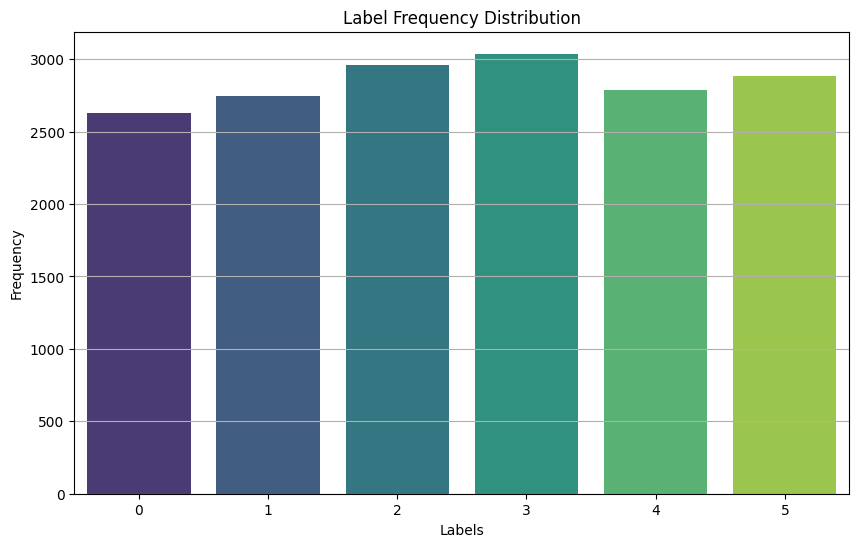

In [12]:
# Count frequency of each label
label_counts = np.bincount(all_labels)
print(label_counts)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(6), y=label_counts, palette='viridis')
plt.title('Label Frequency Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(6))  # Set x-ticks to be labels 0 to 5
plt.grid(axis='y')

# Show the plot
plt.show()

In [13]:
max(label_counts) - min(label_counts)

409

Imagens com label encoded:

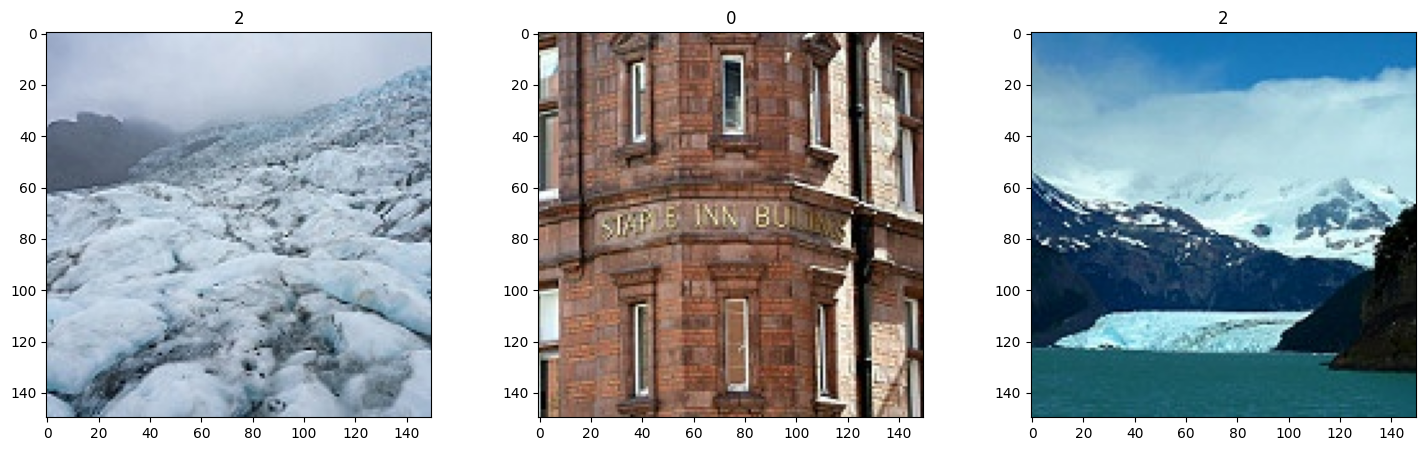

In [14]:
plt.figure(figsize=(18, 5))
for i in range(3):
    random_index = np.random.randint(len(all_images))
    plt.subplot(1, 3, i+1)
    plt.axis(True)
    plt.imshow(all_images[random_index])
    plt.title(all_labels[random_index])
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

### Dividindo treino/validacao/teste

As variáveis com prefixo reserve servem para realizar copy posteriormente. Descobri empiricamente que reutilizar variáveis não funciona, as dimensões são reduzidas in-place. É realizado o escalonamento para o range [0, 1]

In [15]:
all_images = all_images.astype('float32') / 255.0

X, test_X, y, test_y = train_test_split(all_images, all_labels, test_size=0.15, random_state=RANDOM_STATE)
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.15, random_state=RANDOM_STATE)

reserve_train_X = train_X.copy()
reserve_val_X = val_X.copy()
reserve_test_X = test_X.copy()
reserve_train_y = train_y.copy()
reserve_val_y = val_y.copy()
reserve_test_y = test_y.copy()

reserve_train_y = to_categorical(reserve_train_y)
reserve_val_y = to_categorical(reserve_val_y)
reserve_test_y = to_categorical(reserve_test_y)

print(f"train X shape: {train_X.shape}")
print(f"test X shape: {test_X.shape}")
print(f"val X shape: {val_X.shape}")
print(f"train y shape: {train_y.shape}")
print(f"test y shape: {test_y.shape}")
print(f"val y shape: {val_y.shape}")

train X shape: (12306, 150, 150, 3)
test X shape: (2556, 150, 150, 3)
val X shape: (2172, 150, 150, 3)
train y shape: (12306,)
test y shape: (2556,)
val y shape: (2172,)


## Modelo Baseline

### Categorical Cross Entropy

- Usada em problemas de classificação multi-classe;
- Cross-Entropy: distancia das probabilidades reais das probabilidades preditas
- Quanto menor o valor da perda, mais certeza o modelo tem da previsão -> maior foi a probabilidade atribuída à classe correta

### Definindo o modelo baseline -> 17,524,802 params

In [16]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=25,
    restore_best_weights=True,
		mode='max'
)

def instantiate_baseline_model():
	model = Sequential()

	model.add(Conv2D(32, (3, 3), activation='tanh', input_shape=test_image_data[0].shape))
	model.add(MaxPooling2D((2, 2)))

	model.add(Flatten())
	model.add(Dense(100, activation='tanh'))

	model.add(Dense(6, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.0001)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

	return model

In [17]:
baseline_model = instantiate_baseline_model()
baseline_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 175232)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │      17,523,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             606 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,524,802 (66.85 MB)

 Trainable params: 17,524,802 (66.85 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# one hot encode output
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)
val_y = to_categorical(val_y)

In [19]:
models_path = base_path + "av01_cnn/models/"
baseline_model_filename = "baseline_model.keras"
baseline_model_train_history_filename = "baseline_model.training"

if not os.path.isfile(models_path + baseline_model_filename):
    baseline_train_res = baseline_model.fit(
        train_X,
        train_y,
        epochs=250,
        batch_size=128,
        validation_data=(val_X, val_y),
        callbacks=[early_stopping]
    )

    !mkdir -p "/content/drive/My Drive/Colab Notebooks/av01_cnn/models/"
    baseline_model.save(models_path + baseline_model_filename)
    with open(models_path + baseline_model_train_history_filename, 'wb') as file_pi:
      pickle.dump(baseline_train_res.history, file_pi)
else:
    baseline_model = keras.saving.load_model(models_path + baseline_model_filename)

### Visualizando treinamento

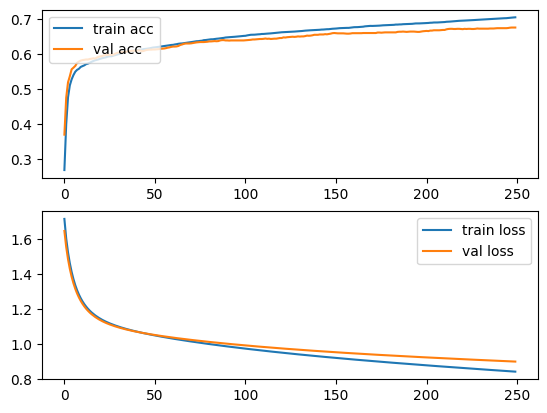

In [20]:
with open(models_path + baseline_model_train_history_filename, 'rb') as file_pi:
  baseline_history = pickle.load(file_pi)

  fig, (ax1, ax2) = plt.subplots(2)

  ax1.plot(baseline_history['accuracy'])
  ax1.plot(baseline_history['val_accuracy'])
  ax1.legend(['train acc', 'val acc'], loc='upper left')

  ax2.plot(baseline_history['loss'])
  ax2.plot(baseline_history['val_loss'])
  ax2.legend(['train loss', 'val loss'], loc='upper right')

  fig.show()

In [21]:
max(baseline_history['val_accuracy'])

0.6749539375305176

In [22]:
min(baseline_history['val_loss'])

0.8985298871994019

## Otimização Bayesiana pelos melhores hiperparâmetros -> 1,928,654

- "num_extra_conv"
- "num_filters"
- "kernel_size"
- "filter_stride"
- "max_pooling_size"
- "max_pooling_stride"
- "num_dense"
- "num_units_dense"
- "activation"
- "learning_rate"
- "l2_alpha" -> o quanto que grandes pesos serão penalizados na função de custo, força que a atualização de pesos minimize esses valores altos

In [23]:
def instantiate_bayesian_optimized_model(hyperparams):
    # Unpacking the list into variables
    num_extra_conv, num_filters, kernel_size, filter_stride, max_pooling_size, max_pooling_stride, num_dense, num_units_dense, activation, learning_rate, l2_alpha = hyperparams.values()

    model = Sequential()

    # convolutional + max pooling layers
    model.add(Conv2D(num_filters, (kernel_size, kernel_size), strides=(filter_stride, filter_stride), activation=activation, input_shape=test_image_data[0].shape, kernel_regularizer=l2(l2_alpha)))
    model.add(MaxPooling2D((max_pooling_size, max_pooling_size), strides=(max_pooling_stride, max_pooling_stride)))

    model.add(Conv2D(num_filters, (kernel_size, kernel_size), strides=(filter_stride, filter_stride), activation=activation, kernel_regularizer=l2(l2_alpha)))
    model.add(MaxPooling2D((max_pooling_size, max_pooling_size), strides=(max_pooling_stride, max_pooling_stride)))

    model.add(Conv2D(num_filters, (kernel_size, kernel_size), strides=(filter_stride, filter_stride), activation=activation, kernel_regularizer=l2(l2_alpha)))
    model.add(MaxPooling2D((max_pooling_size, max_pooling_size), strides=(max_pooling_stride, max_pooling_stride)))

    for i in range(num_extra_conv):
        model.add(Conv2D(num_filters, (kernel_size, kernel_size), strides=(filter_stride, filter_stride), activation=activation, kernel_regularizer=l2(l2_alpha)))
        model.add(MaxPooling2D((max_pooling_size, max_pooling_size), strides=(max_pooling_stride, max_pooling_stride)))

    # dense layers
    model.add(Flatten())
    for i in range(num_dense):
        model.add(Dense(num_units_dense, activation=activation, kernel_regularizer=l2(l2_alpha)))
    model.add(Dense(6, activation='softmax'))

    # optimizer
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def build_optimization_model(hp):
    hyperparams = {
        "num_extra_conv": hp.Int("num_extra_conv", min_value=0, max_value=1, step=1),
        "num_filters": hp.Int("num_filters", min_value=8, max_value=128, step=8),
        "kernel_size": hp.Choice("kernel_size", [2, 3, 4]),
        "filter_stride": hp.Choice("filter_stride", [1, 2]),
        "max_pooling_size": hp.Choice("max_pooling_size", [1, 2, 3]),
        "max_pooling_stride": hp.Choice("max_pooling_stride", [1, 2]),
        "num_dense": hp.Int("num_dense", min_value=1, max_value=3, step=1),
        "num_units_dense": hp.Int("num_units_dense", min_value=128, max_value=512, step=128),
        "activation": hp.Choice("activation", ['relu', 'tanh', 'sigmoid']),
        "learning_rate": hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'),
        "l2_alpha": hp.Float('l2_alpha', min_value=1e-4, max_value=1e-2, sampling='log')
    }

    # call existing model-building code with the hyperparameter values.
    model = instantiate_bayesian_optimized_model(hyperparams)
    return model


build_optimization_model(keras_tuner.HyperParameters())


<Sequential name=sequential_1, built=True>

In [24]:
bayesian_optimized_model_filename = "bayesian_optimized.keras"
bayesian_optimized_model_training_filename = "bayesian_optimized.training"
bayesian_optimized_hyperparams = "bayesian_optimized.hyperparams.txt"

if not os.path.isfile(models_path + bayesian_optimized_model_filename):
    model_checkpoint_callback = ModelCheckpoint(
      filepath=models_path + bayesian_optimized_model_filename,
      # save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True
    )

    tuner = keras_tuner.BayesianOptimization(
        build_optimization_model,
        objective='val_accuracy',
        seed=RANDOM_STATE,
        max_trials=25,
        overwrite = True,
        max_retries_per_trial=1,
        max_consecutive_failed_trials=50,
    )

    # Perform the search
    tuner.search(
        reserve_train_X.copy(), reserve_train_y.copy(),
        epochs=250,
        validation_data=(reserve_val_X.copy(), reserve_val_y.copy()),
        callbacks=[early_stopping, model_checkpoint_callback],
        batch_size=128,
        verbose=1,
    )

    # Retrieve the best model
    best_model = tuner.get_best_models(num_models=1)[0]

    # Print the best hyperparameters
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best hyperparameters: {best_hyperparameters.values}")

    best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
    history = best_trial.metrics.metrics

    !mkdir -p "/content/drive/My Drive/Colab Notebooks/av01_cnn/models/"
    best_model.save(models_path + bayesian_optimized_model_filename)

    optimized_model = best_model

    with open(models_path + bayesian_optimized_hyperparams, 'w') as f:
      f.write(f"{best_hyperparameters.values}")

    with open(models_path + bayesian_optimized_model_training_filename, 'wb') as file_pi:
      pickle.dump(history, file_pi)
else:
    optimized_model = keras.saving.load_model(models_path + bayesian_optimized_model_filename)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [25]:
optimized_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 147, 147, 24)        │           1,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 73, 73, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 70, 70, 24)          │           9,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 34, 34, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 31, 31, 24)          │           9,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,382,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,408,940 (16.82 MB)

 Trainable params: 1,469,646 (5.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,939,294 (11.21 MB)

In [26]:
with open(models_path + bayesian_optimized_model_training_filename, 'rb') as file_pi:
  optimization_history = pickle.load(file_pi)
  print(optimization_history)
  print(optimization_history['val_accuracy'].get_history())
  print(optimization_history['val_loss'].get_history())

{'accuracy': <keras_tuner.src.engine.metrics_tracking.MetricHistory object at 0x7ac0a0197d00>, 'loss': <keras_tuner.src.engine.metrics_tracking.MetricHistory object at 0x7ac0dd64ac50>, 'val_accuracy': <keras_tuner.src.engine.metrics_tracking.MetricHistory object at 0x7ac0a012a500>, 'val_loss': <keras_tuner.src.engine.metrics_tracking.MetricHistory object at 0x7ac0a012b8b0>}
[MetricObservation(value=[0.8342541456222534], step=16)]
[MetricObservation(value=[0.6619243621826172], step=16)]


## Fine Tuning sobre a rede Inception V3

In [27]:
  pre_trained_filename = 'pre_trained.keras'
  pre_trained_first_training_filename = 'pre_trained_first.training'
  pre_trained_training_filename = 'pre_trained.training'

In [28]:
if not os.path.isfile(models_path + pre_trained_filename):

  pre_trained_early_stopping = EarlyStopping(
      monitor='val_accuracy',
      patience=25,
      restore_best_weights=True,
      mode='max'
  )

  # create the base pre-trained model
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=test_image_data[0].shape) #include_top=False means that only conv layers will be used

  # add a global spatial average pooling layer
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  # let's add a fully-connected layer
  x = Dense(512, activation='relu')(x)
  # and a logistic layer -- let's say we have 200 classes
  predictions = Dense(6, activation='softmax')(x)

  # this is the model we will train
  model = Model(inputs=base_model.input, outputs=predictions)

  # first: train only the top layers (which were randomly initialized)
  # i.e. freeze all convolutional InceptionV3 layers
  for layer in base_model.layers:
      layer.trainable = False

  # compile the model (should be done *after* setting layers to non-trainable)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # train the model on the new data for a few epochs
  first_train = model.fit(
      reserve_train_X.copy(),
      reserve_train_y.copy(),
      epochs=250,
      batch_size=128,
      validation_data=(reserve_val_X.copy(), reserve_val_y.copy()),
      callbacks=[pre_trained_early_stopping]
  )
  with open(models_path + pre_trained_first_training_filename, 'wb') as file_pi:
    pickle.dump(first_train, file_pi)

  # at this point, the top layers are well trained and we can start fine-tuning
  # convolutional layers from inception V3. We will freeze the bottom N layers
  # and train the remaining top layers.

  # let's visualize layer names and layer indices to see how many layers
  # we should freeze:
  for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

  # we chose to train the top 2 inception blocks, i.e. we will freeze
  # the first 249 layers and unfreeze the rest:
  for layer in model.layers[:249]:
    layer.trainable = False
  for layer in model.layers[249:]:
    layer.trainable = True

  # we need to recompile the model for these modifications to take effect
  # we use SGD with a low learning rate
  from keras.optimizers import SGD
  model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

  # we train our model again (this time fine-tuning the top 2 inception blocks
  # alongside the top Dense layers

  model_checkpoint_callback = ModelCheckpoint(
    filepath=models_path + pre_trained_filename,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
  )

  pre_trained_history = model.fit(
      reserve_train_X.copy(),
      reserve_train_y.copy(),
      epochs=250,
      batch_size=128,
      validation_data=(reserve_val_X.copy(), reserve_val_y.copy()),
      callbacks=[pre_trained_early_stopping, model_checkpoint_callback]
      # callbacks=[model_checkpoint_callback]
  )

  !mkdir -p "/content/drive/My Drive/Colab Notebooks/av01_cnn/models/"
  model.save(models_path + pre_trained_filename)

  pre_trained = model

  with open(models_path + pre_trained_training_filename, 'wb') as file_pi:
    pickle.dump(pre_trained_history, file_pi)

else:
    pre_trained = keras.saving.load_model(models_path + pre_trained_filename)

In [29]:
pre_trained.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 74, 74, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 35,021,998 (133.60 MB)

 Trainable params: 12,167,046 (46.41 MB)

 Non-trainable params: 10,687,904 (40.77 MB)

 Optimizer params: 12,167,048 (46.41 MB)

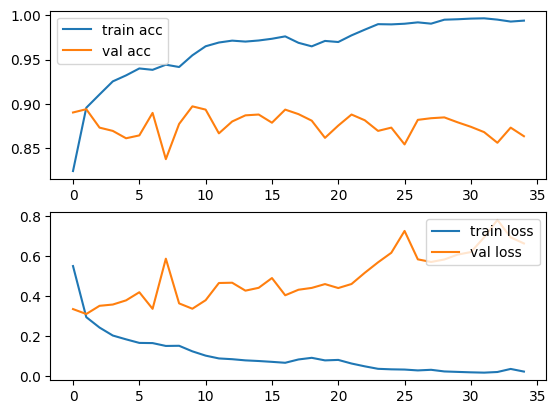

In [30]:
with open(models_path + pre_trained_first_training_filename, 'rb') as file_pi:
  pre_trained_history = pickle.load(file_pi)

  fig, (ax1, ax2) = plt.subplots(2)

  ax1.plot(pre_trained_history.history['accuracy'])
  ax1.plot(pre_trained_history.history['val_accuracy'])
  ax1.legend(['train acc', 'val acc'], loc='upper left')

  ax2.plot(pre_trained_history.history['loss'])
  ax2.plot(pre_trained_history.history['val_loss'])
  ax2.legend(['train loss', 'val loss'], loc='upper right')

  fig.show()

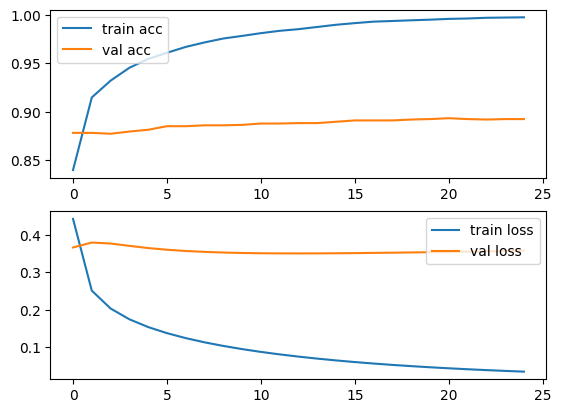

In [31]:
with open(models_path + pre_trained_training_filename, 'rb') as file_pi:
  pre_trained_history = pickle.load(file_pi)

  fig, (ax1, ax2) = plt.subplots(2)

  ax1.plot(pre_trained_history.history['accuracy'])
  ax1.plot(pre_trained_history.history['val_accuracy'])
  ax1.legend(['train acc', 'val acc'], loc='upper left')

  ax2.plot(pre_trained_history.history['loss'])
  ax2.plot(pre_trained_history.history['val_loss'])
  ax2.legend(['train loss', 'val loss'], loc='upper right')

  fig.show()

In [32]:
max(pre_trained_history.history['val_accuracy'])

0.8931860327720642

In [33]:
min(pre_trained_history.history['val_loss'])

0.35028937458992004

O modelo pré-treinado com fine tuning apresentou a performance mais satisfatória entre os 3 modelos testados. Seja pela profundidade capaz de extrair as melhores features das imagens ou os pesos da imagenet, é fato que para esse problema, pelo menos inicialmente, vale muito mais utilizar o pré-treinado do que tentar treinar o próprio modelo especializado

## Predição na base de Teste - 1 experimento

In [34]:
def get_all_metrics(y_true, y_pred, model_name):
  model_acc = accuracy_score(y_true, y_pred)
  print(f"{model_name} accuracy score: {model_acc}")

  model_f1 = f1_score(y_true, y_pred, average='macro')
  print(f"{model_name} f1 score: {model_f1}")

  # Compute precision and recall for each class
  precision = precision_score(y_true, y_pred, average=None)
  recall = recall_score(y_true, y_pred, average=None)

  # Print precision and recall for each class
  for i, (p, r) in enumerate(zip(precision, recall)):
      label = list(categories.keys())[list(categories.values()).index(i)]
      print(f'Model: {model_name}; Class {label}: Precision = {p:.2f}, Recall = {r:.2f}')

In [35]:
def plot_cm(y_true, y_pred, title='Confusion Matrix'):
  # Calculate confusion matrix
  cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5])  # Specify the class labels

  # Plotting the confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
              xticklabels=categories.keys(), yticklabels=categories.keys())
  plt.title(title)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

In [36]:
def plot_error_matrix(y_true, y_pred, title='Error Matrix'):
  # Calculate confusion matrix
  cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5])

  row_sums = cm.sum(axis=1, keepdims=True)
  norm_cm = cm / row_sums
  np.fill_diagonal(norm_cm, 0)

  # Plotting the confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(norm_cm, annot=True, cmap='Reds', cbar=False,
              xticklabels=categories.keys(), yticklabels=categories.keys())
  plt.title(title)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

In [37]:
baseline_model_pred = baseline_model.predict(reserve_test_X.copy())
optimized_model_pred = optimized_model.predict(reserve_test_X.copy())
pre_trained_pred = pre_trained.predict(reserve_test_X.copy())

80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step


In [38]:
baseline_pred_labels = [np.argmax(i) for i in baseline_model_pred]
optimized_pred_labels = [np.argmax(i) for i in optimized_model_pred]
pre_trained_pred_labels = [np.argmax(i) for i in pre_trained_pred]

real_labels = tf.argmax(reserve_test_y, axis=1)

baseline_acc = accuracy_score(baseline_pred_labels, real_labels)
print(f"baseline accuracy score: {baseline_acc}")

opt_acc = accuracy_score(optimized_pred_labels, real_labels)
print(f"optimized accuracy score: {opt_acc}")

pretrained_acc = accuracy_score(pre_trained_pred_labels, real_labels)
print(f"pre trained accuracy score: {pretrained_acc}")

baseline accuracy score: 0.672926447574335
optimized accuracy score: 0.8282472613458529
pre trained accuracy score: 0.8865414710485133


In [39]:
baseline_f1 = f1_score(baseline_pred_labels, real_labels, average='macro')
print(f"baseline f1 score: {baseline_f1}")

opt_f1 = f1_score(optimized_pred_labels, real_labels, average='macro')
print(f"optimized f1 score: {opt_f1}")

pretrained_f1 = f1_score(pre_trained_pred_labels, real_labels, average='macro')
print(f"pre trained f1 score: {pretrained_f1}")

baseline f1 score: 0.6700093919401717
optimized f1 score: 0.829205627211631
pre trained f1 score: 0.8884048265108961


O f1-score está próximo da acurácia quando computando com average macro. Esse resultado é indicativo de uma performance de predição balanceada entre classes. A average macro tira a f1-score para cada classe independentemente e tira a média. Se uma classe tivesse uma performance ruim, puxaria a média para baixo.

As métricas de teste estão próximas das métricas de validação, indicando que os modelos aprenderam bem a generalizar

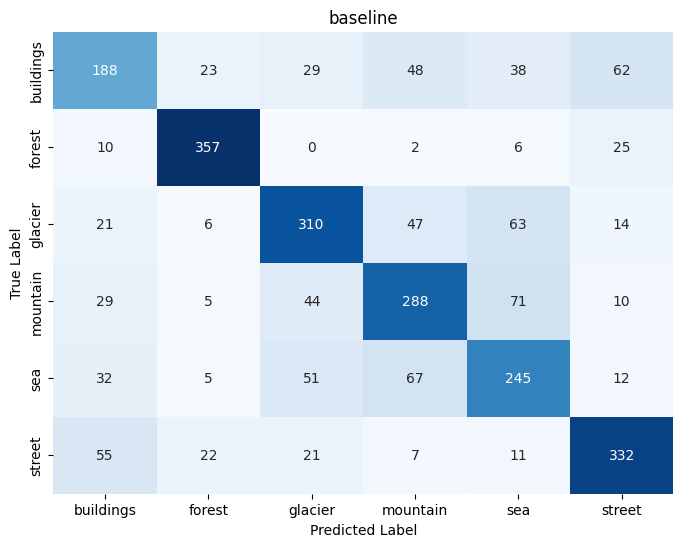

In [40]:
plot_cm(real_labels, baseline_pred_labels, "baseline")

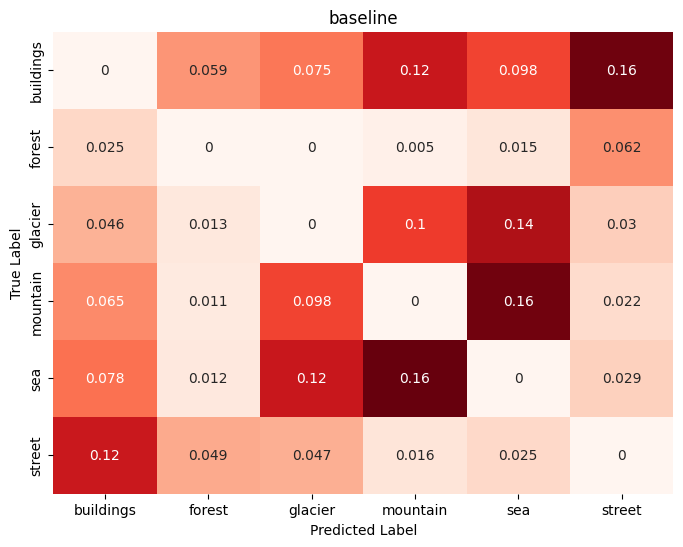

In [41]:
plot_error_matrix(real_labels, baseline_pred_labels, "baseline")

In [42]:
get_all_metrics(real_labels, baseline_pred_labels, "baseline")

baseline accuracy score: 0.672926447574335
baseline f1 score: 0.6700093919401717
Model: baseline; Class buildings: Precision = 0.56, Recall = 0.48
Model: baseline; Class forest: Precision = 0.85, Recall = 0.89
Model: baseline; Class glacier: Precision = 0.68, Recall = 0.67
Model: baseline; Class mountain: Precision = 0.63, Recall = 0.64
Model: baseline; Class sea: Precision = 0.56, Recall = 0.59
Model: baseline; Class street: Precision = 0.73, Recall = 0.74


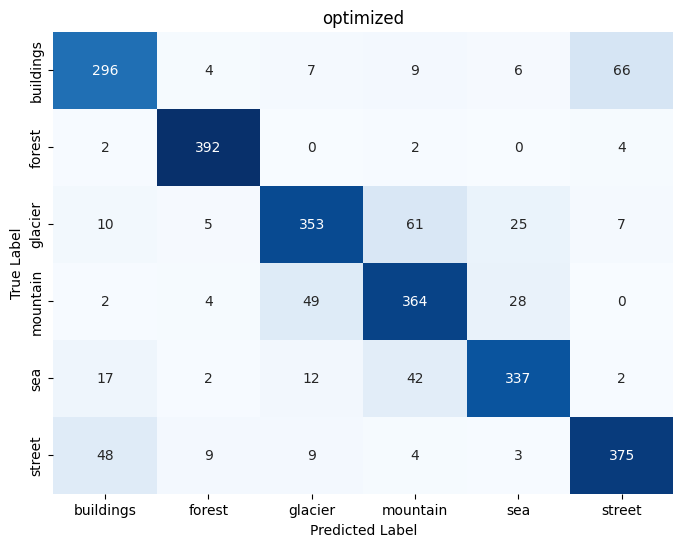

In [43]:
plot_cm(real_labels, optimized_pred_labels, "optimized")

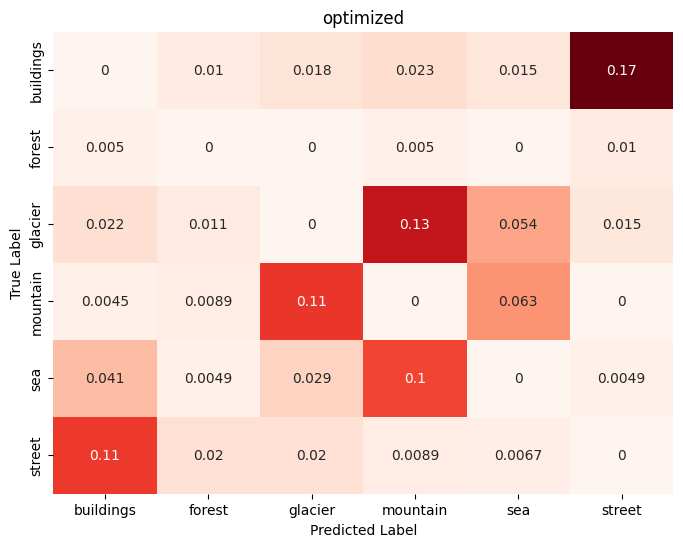

In [44]:
plot_error_matrix(real_labels, optimized_pred_labels, "optimized")

In [45]:
get_all_metrics(real_labels, optimized_pred_labels, "optimized")

optimized accuracy score: 0.8282472613458529
optimized f1 score: 0.829205627211631
Model: optimized; Class buildings: Precision = 0.79, Recall = 0.76
Model: optimized; Class forest: Precision = 0.94, Recall = 0.98
Model: optimized; Class glacier: Precision = 0.82, Recall = 0.77
Model: optimized; Class mountain: Precision = 0.76, Recall = 0.81
Model: optimized; Class sea: Precision = 0.84, Recall = 0.82
Model: optimized; Class street: Precision = 0.83, Recall = 0.84


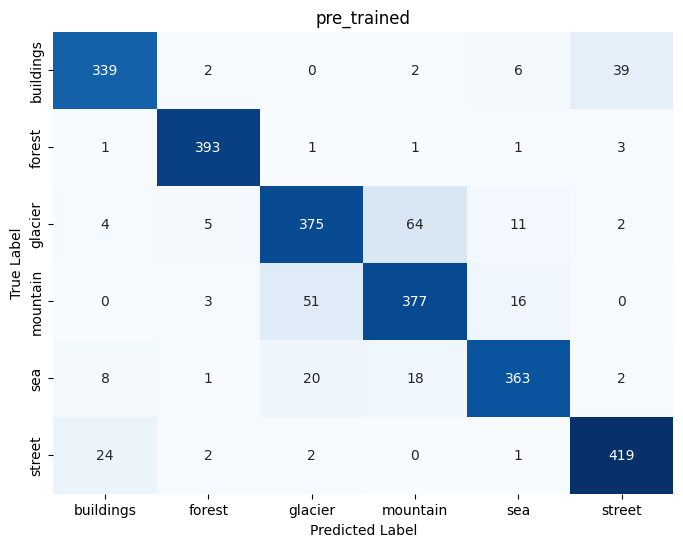

In [46]:
plot_cm(real_labels, pre_trained_pred_labels, "pre_trained")

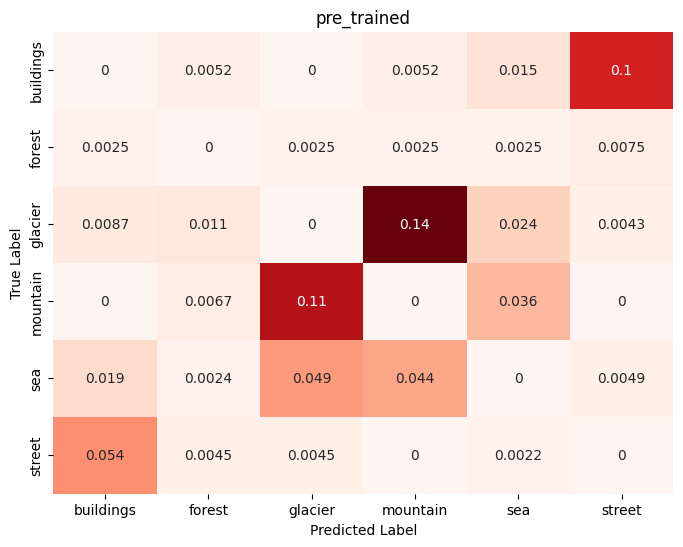

In [47]:
plot_error_matrix(real_labels, pre_trained_pred_labels, "pre_trained")

In [48]:
get_all_metrics(real_labels, pre_trained_pred_labels, "pre_trained")

pre_trained accuracy score: 0.8865414710485133
pre_trained f1 score: 0.8884048265108961
Model: pre_trained; Class buildings: Precision = 0.90, Recall = 0.87
Model: pre_trained; Class forest: Precision = 0.97, Recall = 0.98
Model: pre_trained; Class glacier: Precision = 0.84, Recall = 0.81
Model: pre_trained; Class mountain: Precision = 0.82, Recall = 0.84
Model: pre_trained; Class sea: Precision = 0.91, Recall = 0.88
Model: pre_trained; Class street: Precision = 0.90, Recall = 0.94


## Discussão de Resultados

Entre os modelos é muito comum um erro relativamente grande entre street e buoldings. O erro entre essas duas classes pode ser justificado pois comumente em fotos de ruas há prédios, tal qual em fotos de prédios há ruas.

As classes 2, 3 e 4, respectivamente glacier, mountain e sea formam um "quadrante de incerteza" na matriz de confusão para todos os modelos. Uma inspeção da base de treino mostra que isso faz sentido, pois ocasionalmente são encontradas porções de mar em fotos de geleiras, ou em fotos de montanhas, além de partes rochosas próximas ao mar em fotos de oceanos, e outras combinações. Para validar essa teoria seria necessário printar as feature maps.

A classe que os modelos consistentemente aprendem melhor é a 1, forest. Também faz sentido lógico se você considerar que nenhuma outra classe tem formatos similares aos de uma floresta. Novamente, é válido printar as feature maps para validar quais features as camadas convolucionais extraem das imagens.

Sugestões para melhoria das predições:
- Conseguir magens de maior resolução
- Conseguir mais imagens
- Modelo mais profundo OU busca por hiperparâmetros em um espaço de busca maior com mais tentativas
- Testar formas de regularização diferentes além da L2
- Testar diferentes configurações do modelo pré-treinado, com busca por hiperparâmetros extras, regularização, etc..
- Testar ensembles de modelos
- Criar modelos especialistas em cada classe e classificar a entrada num esquema One Versus All

## Experimento Extra -> InceptionV3 + Bayesian Optimizer

In [49]:
opt_pretrained_filename = "opt_pretrained.keras"
finetuning_opt_pretrained_training_filename = "opt_pretrained.training"
pretrained_bayesian_optimized_hyperparams = "pretrained_bayesian_optimized.hyperparams.txt"

In [50]:
def instantiate_pretrained_bayesian_optimized_model(hyperparams):
    num_dense, num_units_dense, activation, learning_rate, l2_alpha = hyperparams.values()

    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=test_image_data[0].shape) #include_top=False means that only conv layers will be used

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    for _ in range(num_dense):
      x = Dense(num_units_dense, activation=activation, kernel_regularizer=l2(l2_alpha))(x)

    predictions = Dense(6, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def build_pretrained_optimization_model(hp):
    hyperparams = {
        "num_dense": hp.Int("num_dense", min_value=1, max_value=6, step=1),
        "num_units_dense": hp.Int("num_units_dense", min_value=128, max_value=512, step=64),
        "activation": hp.Choice("activation", ['relu', 'tanh', 'sigmoid']),
        "learning_rate": hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'),
        "l2_alpha": hp.Float('l2_alpha', min_value=1e-4, max_value=1e-2, sampling='log')
    }

    # call existing model-building code with the hyperparameter values.
    model = instantiate_pretrained_bayesian_optimized_model(hyperparams)
    return model


build_pretrained_optimization_model(keras_tuner.HyperParameters())


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


<Functional name=functional_29, built=True>

In [51]:
if not os.path.isfile(models_path + opt_pretrained_filename):
    model_checkpoint_callback = ModelCheckpoint(
      filepath=models_path + opt_pretrained_filename,
      # save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True
    )

    tuner = keras_tuner.BayesianOptimization(
        build_pretrained_optimization_model,
        objective='val_accuracy',
        seed=RANDOM_STATE,
        max_trials=20,
        overwrite = True,
        max_retries_per_trial=1,
        max_consecutive_failed_trials=20,
    )

    # Perform the search
    tuner.search(
        reserve_train_X.copy(), reserve_train_y.copy(),
        epochs=250,
        validation_data=(reserve_val_X.copy(), reserve_val_y.copy()),
        callbacks=[early_stopping, model_checkpoint_callback],
        batch_size=128,
        verbose=1,
    )

    # Retrieve the best model
    model = tuner.get_best_models(num_models=1)[0]

    # Print the best hyperparameters
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best hyperparameters: {best_hyperparameters.values}")

    best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
    history = best_trial.metrics.metrics

    for layer in model.layers[:249]:
      layer.trainable = False
    for layer in model.layers[249:]:
      layer.trainable = True

    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate
    from keras.optimizers import SGD
    model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

    opt_pre_trained_history = model.fit(
        reserve_train_X.copy(),
        reserve_train_y.copy(),
        epochs=250,
        batch_size=128,
        validation_data=(reserve_val_X.copy(), reserve_val_y.copy()),
        callbacks=[pre_trained_early_stopping, model_checkpoint_callback]
    )

    !mkdir -p "/content/drive/My Drive/Colab Notebooks/av01_cnn/models/"
    model.save(models_path + opt_pretrained_filename)

    pretrained_optimized_model = model

    with open(models_path + pretrained_bayesian_optimized_hyperparams, 'w') as f:
      f.write(f"{best_hyperparameters.values}")

    with open(models_path + finetuning_opt_pretrained_training_filename, 'wb') as file_pi:
      pickle.dump(opt_pre_trained_history, file_pi)
else:
    pretrained_optimized_model = keras.saving.load_model(models_path + opt_pretrained_filename)

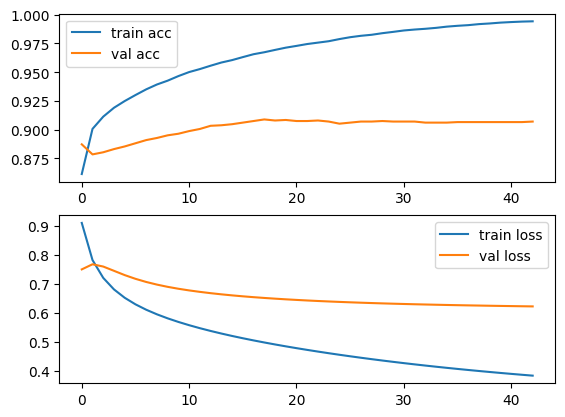

In [52]:
with open(models_path + finetuning_opt_pretrained_training_filename, 'rb') as file_pi:
  opt_pretrained_history = pickle.load(file_pi)

  fig, (ax1, ax2) = plt.subplots(2)

  ax1.plot(opt_pretrained_history.history['accuracy'])
  ax1.plot(opt_pretrained_history.history['val_accuracy'])
  ax1.legend(['train acc', 'val acc'], loc='upper left')

  ax2.plot(opt_pretrained_history.history['loss'])
  ax2.plot(opt_pretrained_history.history['val_loss'])
  ax2.legend(['train loss', 'val loss'], loc='upper right')

  fig.show()

In [53]:
max(opt_pretrained_history.history['val_accuracy'])

0.908839762210846

In [54]:
min(opt_pretrained_history.history['val_loss'])

0.6215559244155884

In [55]:
pre_trained_opt_pred = pretrained_optimized_model.predict(reserve_test_X.copy())

80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step


In [56]:
pre_trained_opt_pred_labels = [np.argmax(i) for i in pre_trained_opt_pred]

pretrained_opt_acc = accuracy_score(pre_trained_opt_pred_labels, real_labels)
print(f"pretrained + optimization accuracy score: {pretrained_opt_acc}")

pretrained + optimization accuracy score: 0.9006259780907668


In [57]:
pretrained_opt_f1 = f1_score(pre_trained_opt_pred_labels, real_labels, average='macro')
print(f"pre trained f1 score: {pretrained_opt_f1}")

pre trained f1 score: 0.9030271537867326


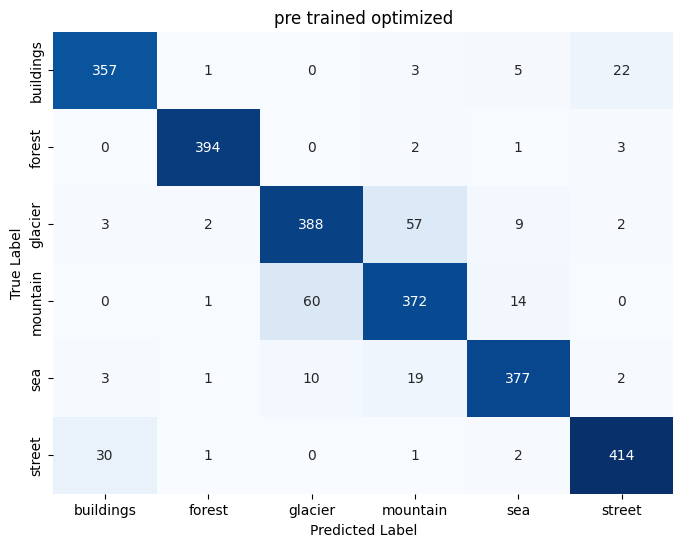

In [58]:
plot_cm(real_labels, pre_trained_opt_pred_labels, "pre trained optimized")

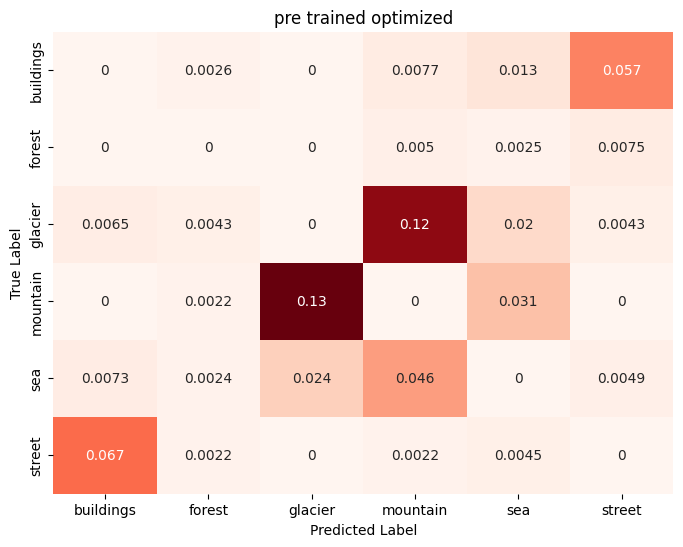

In [59]:
plot_error_matrix(real_labels, pre_trained_opt_pred_labels, "pre trained optimized")

In [60]:
get_all_metrics(real_labels, pre_trained_opt_pred_labels, "pre trained optimized")

pre trained optimized accuracy score: 0.9006259780907668
pre trained optimized f1 score: 0.9030271537867326
Model: pre trained optimized; Class buildings: Precision = 0.91, Recall = 0.92
Model: pre trained optimized; Class forest: Precision = 0.98, Recall = 0.98
Model: pre trained optimized; Class glacier: Precision = 0.85, Recall = 0.84
Model: pre trained optimized; Class mountain: Precision = 0.82, Recall = 0.83
Model: pre trained optimized; Class sea: Precision = 0.92, Recall = 0.92
Model: pre trained optimized; Class street: Precision = 0.93, Recall = 0.92


Esse último modelo reduz o total de erros consideravelmente, logo, reduz o erro relativo também. Ele consegue zerar o erro de previsão para alguns pares de classes, mas ainda comete os mesmos erros de previsão concentrados em street, sea, mountain, glacier e buildings. Novamente, deve-se visualizar os feature maps para ter uma noção melhor de como o modelo extrai features, e a partir disso desenvolver formas de separar melhor as caracteristicas da imagem.

Para reduzir o erro entre classes semelhates, pode-se tomar as seguintes medidas:
- Data Augmentation (rotacionar, flipar, adicionar ruído, zoom, pad, crop, mexer com os canais de cor...)
- Aprofundar os modelos
- ...

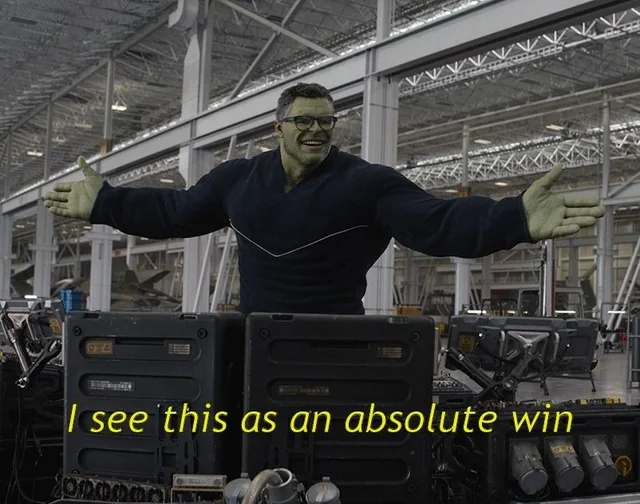

Agora é sério... sugestões para um próximo experimento:
- Testar mais possibilidades com o modelo pré-treinado: não realizar fine tuning, não adicionar camadas densas...
- Testar outro modelo pré-treinado
- Testar pesos de diferentes bases de imagens
- Testar fine-tuning com diferentes camadas de inception...
- Testar Data Augmentation (lib disponível no Keras)

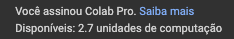

## Predição na base de Teste - 30 experimentos

In [61]:
def fit_and_predict(model, train_X, train_y, val_X, val_y, test_X):
    model.fit(
        train_X,
        train_y,
        epochs=250,
        batch_size=128,
        validation_data=(val_X, val_y),
        callbacks=[early_stopping],
        verbose = 0
    )

    return model.predict(test_X)

In [62]:
metrics_baseline = list()
metrics_opt = list()
metrics_pretrained = list()
metrics_pretrained_opt = list()

In [63]:
len(real_labels)

2556

In [64]:
if not os.path.isfile(models_path + "metrics_baseline"):

  start = datetime.now()

  for i in range(30):
      print(f"{'-' * 20} ITERATION {i+1} {'-' * 20}")

      baseline_pred = fit_and_predict(baseline_model, reserve_train_X.copy(), reserve_train_y.copy(), reserve_val_X.copy(), reserve_val_y.copy(), reserve_test_X.copy())
      optimized_pred = fit_and_predict(optimized_model, reserve_train_X.copy(), reserve_train_y.copy(), reserve_val_X.copy(), reserve_val_y.copy(), reserve_test_X.copy())
      pretrained_pred = fit_and_predict(pre_trained, reserve_train_X.copy(), reserve_train_y.copy(), reserve_val_X.copy(), reserve_val_y.copy(), reserve_test_X.copy())
      pretrained_opt_pred = fit_and_predict(pretrained_optimized_model, reserve_train_X.copy(), reserve_train_y.copy(), reserve_val_X.copy(), reserve_val_y.copy(), reserve_test_X.copy())

      baseline_pred_labels = [np.argmax(p) for p in baseline_pred]
      metrics_baseline.append(accuracy_score(baseline_pred_labels, real_labels))

      opt_pred_labels = [np.argmax(i) for i in optimized_pred]
      metrics_opt.append(accuracy_score(opt_pred_labels, real_labels))

      pretrained_pred_labels = [np.argmax(i) for i in pretrained_pred]
      metrics_pretrained.append(accuracy_score(pretrained_pred_labels, real_labels))

      pretrained_opt_pred_labels = [np.argmax(i) for i in pretrained_opt_pred]
      metrics_pretrained_opt.append(accuracy_score(pretrained_opt_pred_labels, real_labels))

  print(f"{'-' * 20} TIME ELAPSED {'-' * 20}")
  print(datetime.now() - start)

  with open(models_path + "metrics_baseline", 'wb') as file_pi:
    pickle.dump(metrics_baseline, file_pi)

  with open(models_path + "metrics_opt", 'wb') as file_pi:
    pickle.dump(metrics_opt, file_pi)

  with open(models_path + "metrics_pretrained", 'wb') as file_pi:
    pickle.dump(metrics_pretrained, file_pi)

  with open(models_path + "metrics_pretrained_opt", 'wb') as file_pi:
    pickle.dump(metrics_pretrained_opt, file_pi)

else:
  with open(models_path + "metrics_baseline", 'rb') as file_pi:
    metrics_baseline = pickle.load(file_pi)

  with open(models_path + "metrics_opt", 'rb') as file_pi:
    metrics_opt = pickle.load(file_pi)

  with open(models_path + "metrics_pretrained", 'rb') as file_pi:
    metrics_pretrained = pickle.load(file_pi)

  with open(models_path + "metrics_pretrained_opt", 'rb') as file_pi:
    metrics_pretrained_opt = pickle.load(file_pi)

In [65]:
for i, acc in enumerate(metrics_pretrained_opt):
    # pred_labels = [np.argmax(i) for i in pred]
    print(acc)

0.9014084507042254
0.9014084507042254
0.9006259780907668
0.9006259780907668
0.901017214397496
0.901017214397496
0.9021909233176839
0.9029733959311425
0.9029733959311425
0.9025821596244131
0.9021909233176839
0.9025821596244131
0.9029733959311425
0.9029733959311425
0.9029733959311425
0.9025821596244131
0.9025821596244131
0.9033646322378717
0.9029733959311425
0.9033646322378717
0.9029733959311425
0.9029733959311425
0.9021909233176839
0.9021909233176839
0.9029733959311425
0.9029733959311425
0.9029733959311425
0.9025821596244131
0.9025821596244131
0.9025821596244131


In [66]:
def normal_komolgorov_smirnov(array: np.ndarray):
    ks_statistic, p_value = kstest(array, 'norm')

    print(f"KS Statistic: {ks_statistic}")
    print(f"P-Value: {p_value}")

    if p_value < 0.05:
        print("H0 rejected, distribution can't be said Normal")
    else:
        print("H0 is not rejected, possibly normal distribution")

    return ks_statistic, p_value

Friedman Chi-Squared: para comprovar a hipótese de nulidade de que três ou mais amostras tenham sido extraídas da mesma população ou de populações com a mesma mediana. Utiliza o conceito de ranks para que os dados não necessitem ser normalmente distribuídos

In [67]:
def friedman_chi_squared(classifier1, classifier2, classifier3, classifier4):
  stat, p_value = friedmanchisquare(classifier1, classifier2, classifier3, classifier4)

  print(f'Friedman Test Statistic: {stat}')
  print(f'P-value: {p_value}')

  # Interpret the result
  alpha = 0.05
  if p_value < alpha:
      print("H0 rejected. There is a statistically significant difference between the classifiers.")
  else:
      print("H0 not rejected. No statistically significant difference between the classifiers.")

Wilcoxon: É um teste de hipóteses não paramétrico que compara duas amostras relacionadas, como medidas repetidas em uma mesma amostra. É uma alternativa ao teste t de Student, quando não se pode assumir que a população é normalmente distribuída.

In [68]:
def pair_to_pair_wilcoxon(classifier1, classifier2, classifier3, classifier4):
  comparisons = [
      (classifier1, classifier2, "Classifier 1 vs Classifier 2"),
      (classifier1, classifier3, "Classifier 1 vs Classifier 3"),
      (classifier1, classifier4, "Classifier 1 vs Classifier 4"),
      (classifier2, classifier3, "Classifier 2 vs Classifier 3"),
      (classifier2, classifier4, "Classifier 2 vs Classifier 4"),
      (classifier3, classifier4, "Classifier 3 vs Classifier 4")
  ]

  # Iterate over pairs and perform the Wilcoxon test
  for clf1, clf2, description in comparisons:
      stat, p_value = wilcoxon(clf1, clf2, alternative='two-sided')
      print(f"{description}: Wilcoxon Test Statistic = {stat}, P-value = {p_value}")

      alpha = 0.05
      # Interpret each test result
      if p_value < alpha:
          print(f"H0 Rejected. Significant difference between {description}")
      else:
          print(f"H0 not rejected. No significant difference between {description}")
      print("\n")

In [69]:
def single_pair_wilcoxon(clf1, clf2):
  stat, p_value = wilcoxon(clf1, clf2, alternative='two-sided')

  alpha = 0.05
  # Interpret each test result
  if p_value < alpha:
      print(f"H0 Rejected with p-value {p_value}. Significant difference between distributions")
  else:
      print(f"H0 not rejected with p-value {p_value}. No significant difference between distributions")
  print("\n")

### Comparando séries de acurácias

KS Statistic: 0.7516139786795255
P-Value: 4.5940080231671125e-18
H0 rejected, distribution can't be said Normal
KS Statistic: 0.7677972566211313
P-Value: 4.831483115839257e-19
H0 rejected, distribution can't be said Normal
KS Statistic: 0.8141229499555989
P-Value: 3.4900134097615116e-22
H0 rejected, distribution can't be said Normal
KS Statistic: 0.8161063912685838
P-Value: 2.481534512844642e-22
H0 rejected, distribution can't be said Normal


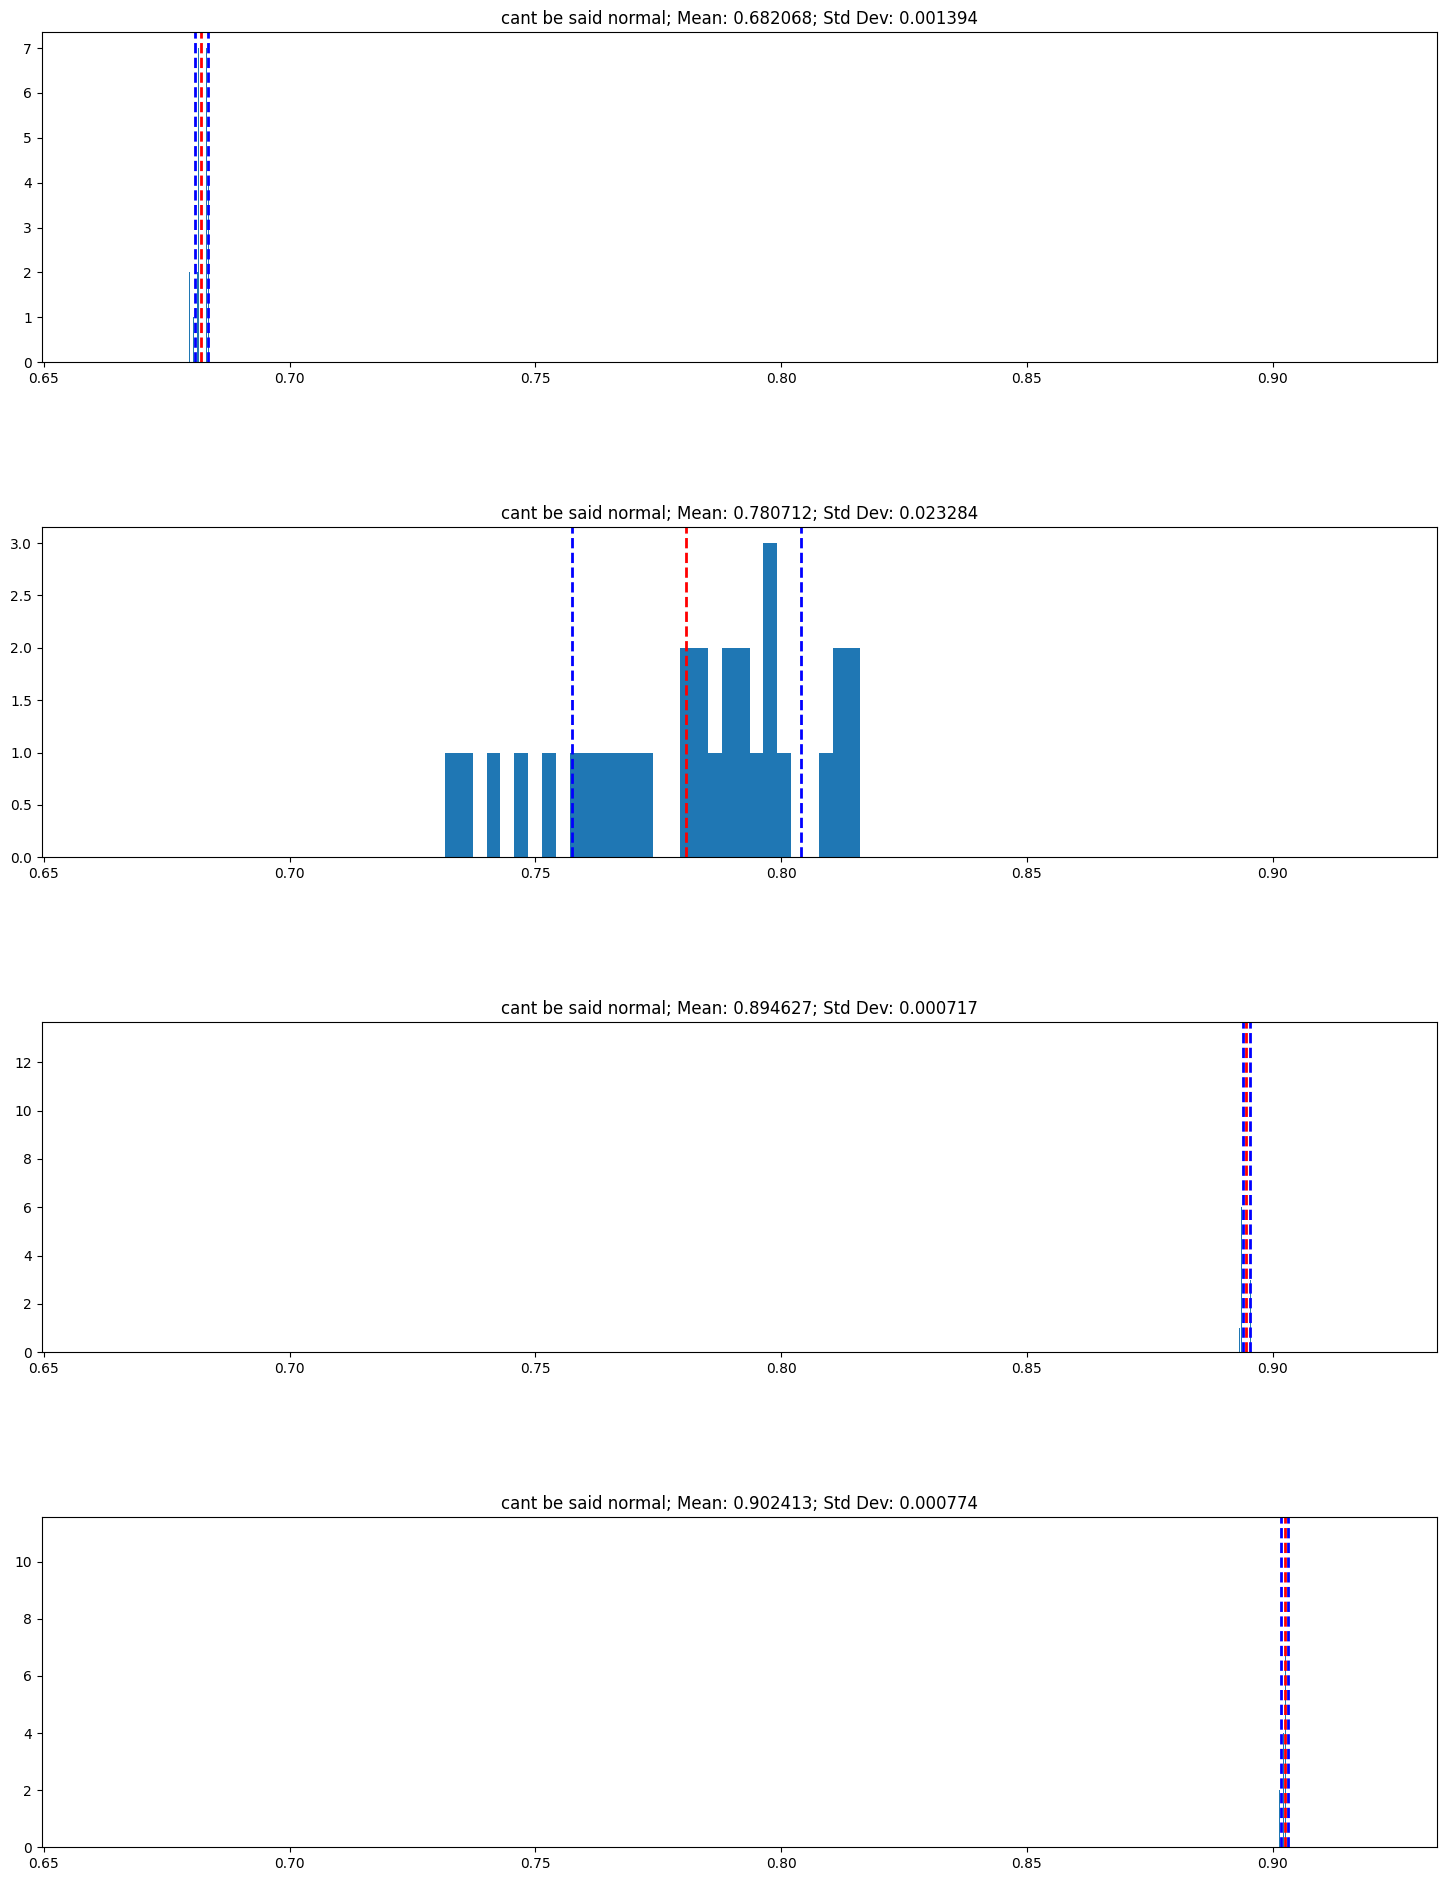

In [70]:
all_data = np.concatenate([metrics_baseline, metrics_opt, metrics_pretrained, metrics_pretrained_opt])
global_min = np.min(all_data)
global_max = np.max(all_data)

plt.figure(figsize=(18, 30))
for i, metrics in enumerate([metrics_baseline, metrics_opt, metrics_pretrained, metrics_pretrained_opt]):

    _, p_value = normal_komolgorov_smirnov(metrics)
    # p_value = 0
    mean = np.array(metrics).mean()
    std_dev = np.array(metrics).std()

    plt.subplot(5, 1, i+1)
    plt.xlim(global_min - 0.03, global_max + 0.03)
    plt.axis(True)
    plt.hist(metrics, bins=len(metrics))
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    plt.axvline(mean + std_dev, color='blue', linestyle='dashed', linewidth=2, label=f'Mean + 1 Std Dev: {mean + std_dev:.2f}')
    plt.axvline(mean - std_dev, color='blue', linestyle='dashed', linewidth=2, label=f'Mean - 1 Std Dev: {mean - std_dev:.2f}')
    plt.title(f"{'cant be said normal' if p_value < 0.05 else 'possibly normal'}; Mean: {mean:.6f}; Std Dev: {std_dev:.6f}")
    plt.subplots_adjust(wspace=0.2, hspace=0.5)

### Testes de hipótese -> Friedman Chi-Square; Wilcoxon

In [71]:
friedman_chi_squared(metrics_baseline, metrics_opt, metrics_pretrained, metrics_pretrained_opt)

Friedman Test Statistic: 90.0
P-value: 2.190570119285308e-19
H0 rejected. There is a statistically significant difference between the classifiers.


In [72]:
pair_to_pair_wilcoxon(metrics_baseline, metrics_opt, metrics_pretrained, metrics_pretrained_opt)

Classifier 1 vs Classifier 2: Wilcoxon Test Statistic = 0.0, P-value = 1.862645149230957e-09
H0 Rejected. Significant difference between Classifier 1 vs Classifier 2


Classifier 1 vs Classifier 3: Wilcoxon Test Statistic = 0.0, P-value = 1.862645149230957e-09
H0 Rejected. Significant difference between Classifier 1 vs Classifier 3


Classifier 1 vs Classifier 4: Wilcoxon Test Statistic = 0.0, P-value = 1.862645149230957e-09
H0 Rejected. Significant difference between Classifier 1 vs Classifier 4


Classifier 2 vs Classifier 3: Wilcoxon Test Statistic = 0.0, P-value = 1.862645149230957e-09
H0 Rejected. Significant difference between Classifier 2 vs Classifier 3


Classifier 2 vs Classifier 4: Wilcoxon Test Statistic = 0.0, P-value = 1.862645149230957e-09
H0 Rejected. Significant difference between Classifier 2 vs Classifier 4


Classifier 3 vs Classifier 4: Wilcoxon Test Statistic = 0.0, P-value = 1.862645149230957e-09
H0 Rejected. Significant difference between Classifier 3 vs Classif

In [73]:
np.array(metrics_baseline)

array([0.67957746, 0.6799687 , 0.6799687 , 0.67957746, 0.6799687 ,
       0.68035994, 0.68153365, 0.68153365, 0.68153365, 0.68153365,
       0.68153365, 0.68114241, 0.68114241, 0.68153365, 0.68153365,
       0.68270736, 0.68270736, 0.68309859, 0.68309859, 0.68309859,
       0.68348983, 0.68348983, 0.68309859, 0.68309859, 0.68309859,
       0.68309859, 0.68348983, 0.68348983, 0.6842723 , 0.6842723 ])

Para os 30 experimentos conduzidos em cada modelo, obtemos acurácias em um range relativamente pequeno. O inicializador de pesos default, Glorot Uniform Initializer, tira valores de um range finito de forma pseudoaleatória, controlado ainda mais fortemente pelo fato de a função tf.random.set_seed(42) ter sido rodada no começo do notebook. Não configurar a semente de aleatoriedade poderia prover um range maior de acurácias para cada experimento.

Com essa semente e esses modelos, re-treinados 30 vezes, observa-se claramente que a distribuição das acurácias não pode ser dita Normal e há sim uma diferença estatística significante entre todas as distribuições, seja conjuntamente ou par a par.

Especialmente analisando par a par, todas as distribuições são significativamente diferentes com p valor de 0.000000001862645149230957, assim rejeitando a Nula para um intervalo de confiança de 95% de que não haveria diferença significativa entre as distribuições.

## Predição na base de Teste - 30 experimentos com seeds de aleatoriedade diferentes

In [74]:
metrics_baseline2 = list()
metrics_opt2 = list()
metrics_pretrained2 = list()
metrics_pretrained_opt2 = list()

In [75]:
if not os.path.isfile(models_path + "metrics_baseline2"):
  start = datetime.now()

  for i in range(30):
      random.seed(i)
      np.random.seed(i)
      tf.random.set_seed(i)
      print(f"{'-' * 20} ITERATION {i+1} {'-' * 20}")

      baseline_pred = fit_and_predict(baseline_model, reserve_train_X.copy(), reserve_train_y.copy(), reserve_val_X.copy(), reserve_val_y.copy(), reserve_test_X.copy())
      optimized_pred = fit_and_predict(optimized_model, reserve_train_X.copy(), reserve_train_y.copy(), reserve_val_X.copy(), reserve_val_y.copy(), reserve_test_X.copy())
      pretrained_pred = fit_and_predict(pre_trained, reserve_train_X.copy(), reserve_train_y.copy(), reserve_val_X.copy(), reserve_val_y.copy(), reserve_test_X.copy())
      pretrained_opt_pred = fit_and_predict(pretrained_optimized_model, reserve_train_X.copy(), reserve_train_y.copy(), reserve_val_X.copy(), reserve_val_y.copy(), reserve_test_X.copy())

      baseline_pred_labels = [np.argmax(p) for p in baseline_pred]
      metrics_baseline2.append(accuracy_score(baseline_pred_labels, real_labels))

      opt_pred_labels = [np.argmax(i) for i in optimized_pred]
      metrics_opt2.append(accuracy_score(opt_pred_labels, real_labels))

      pretrained_pred_labels = [np.argmax(i) for i in pretrained_pred]
      metrics_pretrained2.append(accuracy_score(pretrained_pred_labels, real_labels))

      pretrained_opt_pred_labels = [np.argmax(i) for i in pretrained_opt_pred]
      metrics_pretrained_opt2.append(accuracy_score(pretrained_opt_pred_labels, real_labels))

  print(f"{'-' * 20} TIME ELAPSED {'-' * 20}")
  print(datetime.now() - start)

  with open(models_path + "metrics_baseline2", 'wb') as file_pi:
    pickle.dump(metrics_baseline2, file_pi)

  with open(models_path + "metrics_opt2", 'wb') as file_pi:
    pickle.dump(metrics_opt2, file_pi)

  with open(models_path + "metrics_pretrained2", 'wb') as file_pi:
    pickle.dump(metrics_pretrained2, file_pi)

  with open(models_path + "metrics_pretrained_opt2", 'wb') as file_pi:
    pickle.dump(metrics_pretrained_opt2, file_pi)

else:
  with open(models_path + "metrics_baseline2", 'rb') as file_pi:
    metrics_baseline2 = pickle.load(file_pi)

  with open(models_path + "metrics_opt2", 'rb') as file_pi:
    metrics_opt2 = pickle.load(file_pi)

  with open(models_path + "metrics_pretrained2", 'rb') as file_pi:
    metrics_pretrained2 = pickle.load(file_pi)

  with open(models_path + "metrics_pretrained_opt2", 'rb') as file_pi:
    metrics_pretrained_opt2 = pickle.load(file_pi)

In [76]:
for i, acc in enumerate(metrics_pretrained_opt):
    # pred_labels = [np.argmax(i) for i in pred]
    print(acc)

0.9014084507042254
0.9014084507042254
0.9006259780907668
0.9006259780907668
0.901017214397496
0.901017214397496
0.9021909233176839
0.9029733959311425
0.9029733959311425
0.9025821596244131
0.9021909233176839
0.9025821596244131
0.9029733959311425
0.9029733959311425
0.9029733959311425
0.9025821596244131
0.9025821596244131
0.9033646322378717
0.9029733959311425
0.9033646322378717
0.9029733959311425
0.9029733959311425
0.9021909233176839
0.9021909233176839
0.9029733959311425
0.9029733959311425
0.9029733959311425
0.9025821596244131
0.9025821596244131
0.9025821596244131


### Comparando séries de acurácias

KS Statistic: 0.7594755638068478
P-Value: 1.5620387434296112e-18
H0 rejected, distribution can't be said Normal
KS Statistic: 0.7711279147178993
P-Value: 2.9921325259129887e-19
H0 rejected, distribution can't be said Normal
KS Statistic: 0.8142276712051286
P-Value: 3.4279919356165134e-22
H0 rejected, distribution can't be said Normal
KS Statistic: 0.8161063912685838
P-Value: 2.481534512844642e-22
H0 rejected, distribution can't be said Normal


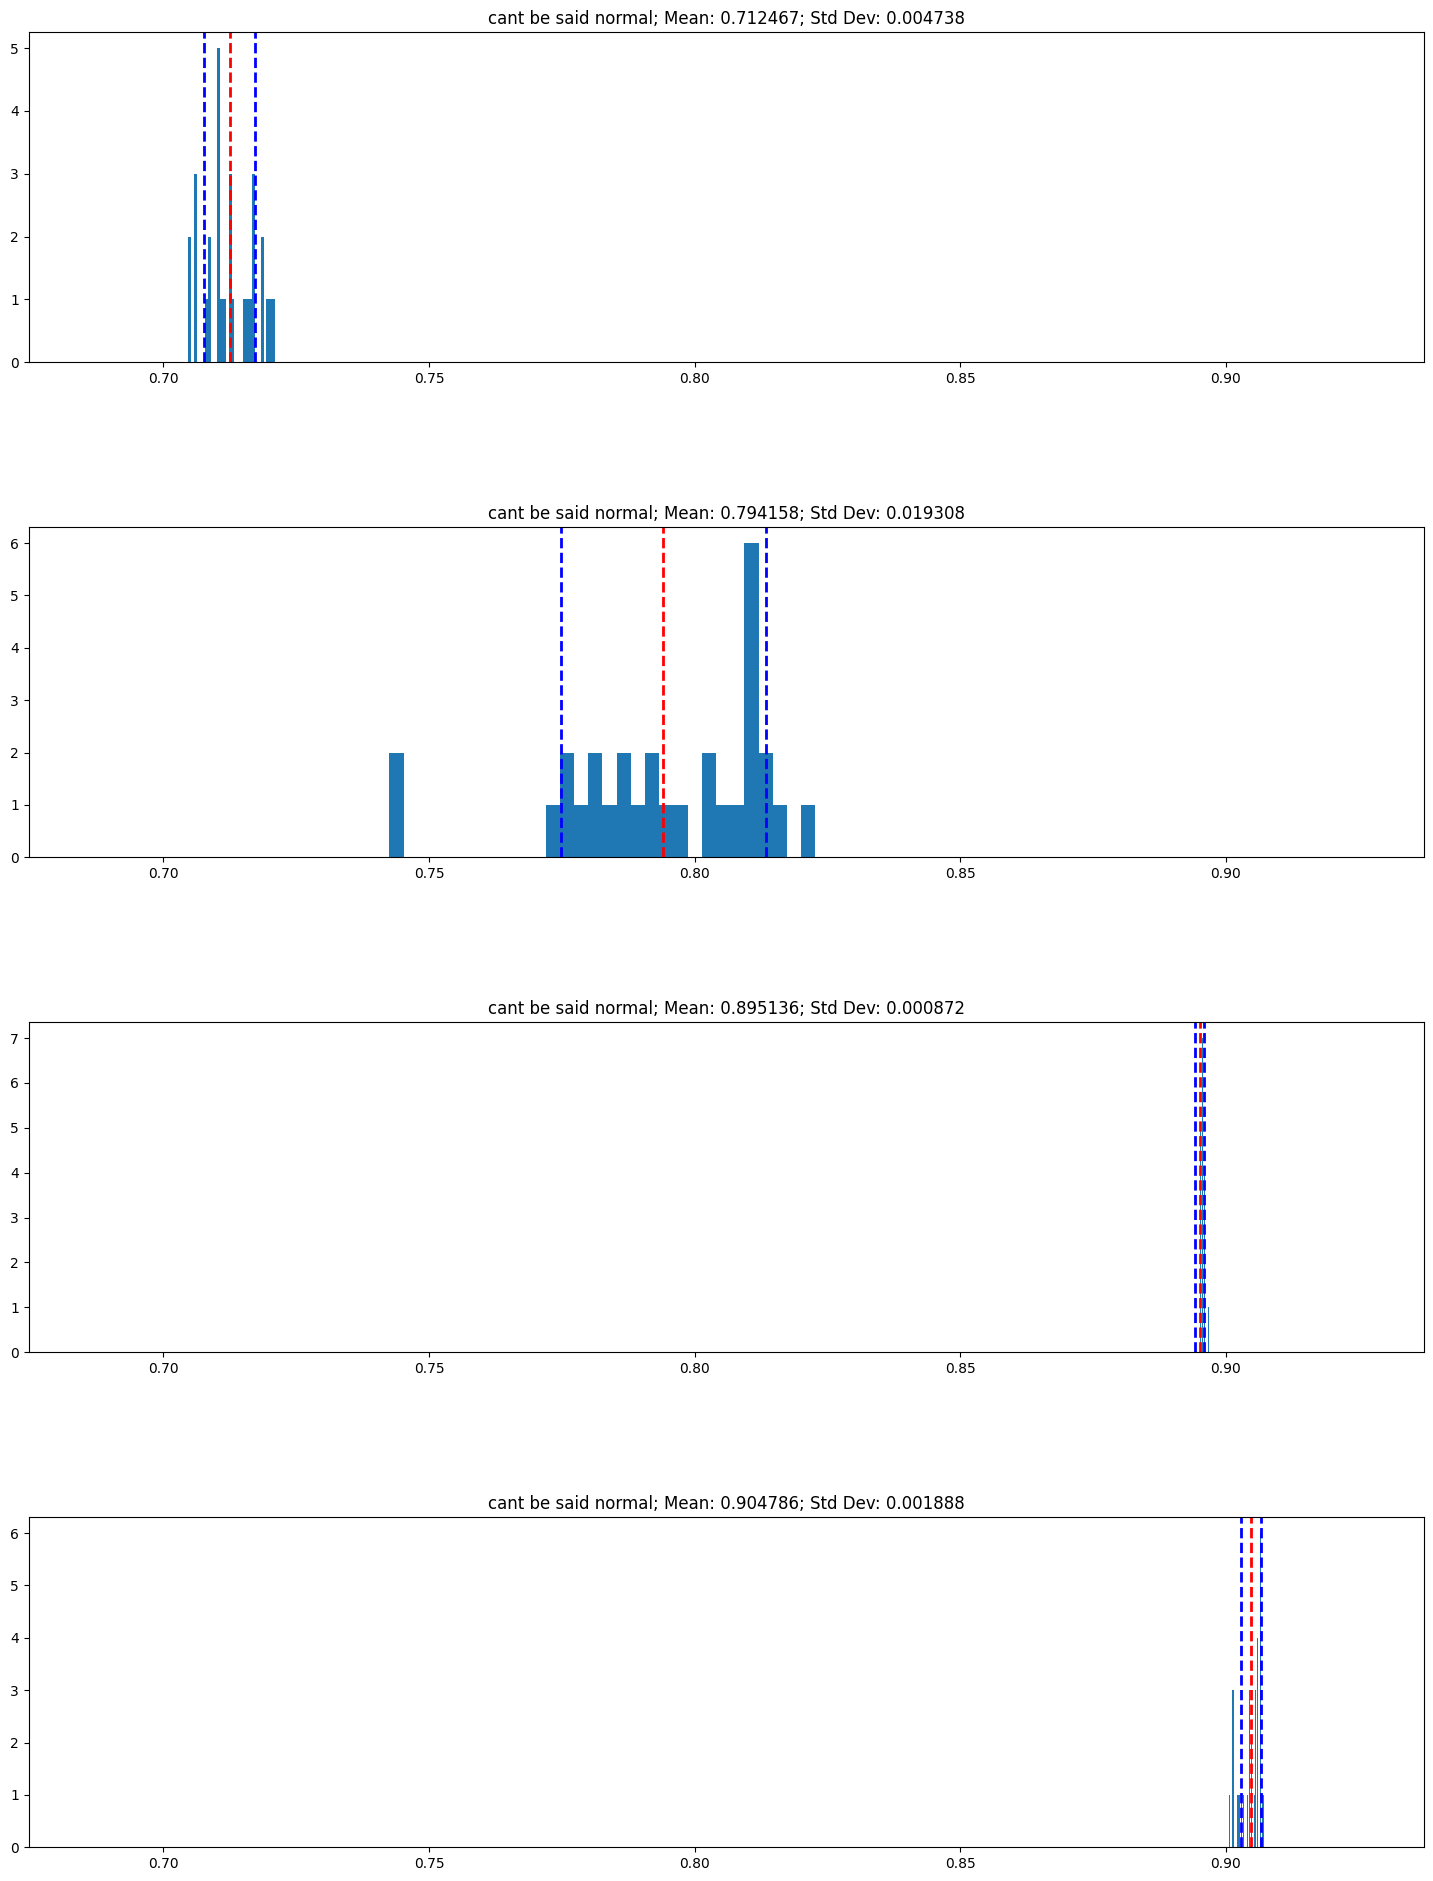

In [77]:
all_data = np.concatenate([metrics_baseline2, metrics_opt2, metrics_pretrained2, metrics_pretrained_opt2])
global_min = np.min(all_data)
global_max = np.max(all_data)

plt.figure(figsize=(18, 30))
for i, metrics in enumerate([metrics_baseline2, metrics_opt2, metrics_pretrained2, metrics_pretrained_opt2]):

    _, p_value = normal_komolgorov_smirnov(metrics)
    # p_value = 0
    mean = np.array(metrics).mean()
    std_dev = np.array(metrics).std()

    plt.subplot(5, 1, i+1)
    plt.xlim(global_min - 0.03, global_max + 0.03)
    plt.axis(True)
    plt.hist(metrics, bins=len(metrics))
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    plt.axvline(mean + std_dev, color='blue', linestyle='dashed', linewidth=2, label=f'Mean + 1 Std Dev: {mean + std_dev:.2f}')
    plt.axvline(mean - std_dev, color='blue', linestyle='dashed', linewidth=2, label=f'Mean - 1 Std Dev: {mean - std_dev:.2f}')
    plt.title(f"{'cant be said normal' if p_value < 0.05 else 'possibly normal'}; Mean: {mean:.6f}; Std Dev: {std_dev:.6f}")
    plt.subplots_adjust(wspace=0.2, hspace=0.5)

### Testes de hipótese

In [78]:
friedman_chi_squared(metrics_baseline2, metrics_opt2, metrics_pretrained2, metrics_pretrained_opt2)

Friedman Test Statistic: 90.0
P-value: 2.190570119285308e-19
H0 rejected. There is a statistically significant difference between the classifiers.


In [79]:
pair_to_pair_wilcoxon(metrics_baseline2, metrics_opt2, metrics_pretrained2, metrics_pretrained_opt2)

Classifier 1 vs Classifier 2: Wilcoxon Test Statistic = 0.0, P-value = 1.862645149230957e-09
H0 Rejected. Significant difference between Classifier 1 vs Classifier 2


Classifier 1 vs Classifier 3: Wilcoxon Test Statistic = 0.0, P-value = 1.862645149230957e-09
H0 Rejected. Significant difference between Classifier 1 vs Classifier 3


Classifier 1 vs Classifier 4: Wilcoxon Test Statistic = 0.0, P-value = 1.862645149230957e-09
H0 Rejected. Significant difference between Classifier 1 vs Classifier 4


Classifier 2 vs Classifier 3: Wilcoxon Test Statistic = 0.0, P-value = 1.862645149230957e-09
H0 Rejected. Significant difference between Classifier 2 vs Classifier 3


Classifier 2 vs Classifier 4: Wilcoxon Test Statistic = 0.0, P-value = 1.862645149230957e-09
H0 Rejected. Significant difference between Classifier 2 vs Classifier 4


Classifier 3 vs Classifier 4: Wilcoxon Test Statistic = 0.0, P-value = 1.862645149230957e-09
H0 Rejected. Significant difference between Classifier 3 vs Classif

Diferença entre distribuições com e sem reset da seed

In [80]:
single_pair_wilcoxon(metrics_baseline, metrics_baseline2)

H0 Rejected with p-value 1.862645149230957e-09. Significant difference between distributions




In [81]:
single_pair_wilcoxon(metrics_opt, metrics_opt2)

H0 Rejected with p-value 0.008705463260412216. Significant difference between distributions




In [82]:
single_pair_wilcoxon(metrics_pretrained, metrics_pretrained2)

H0 Rejected with p-value 0.01111175787862199. Significant difference between distributions




In [83]:
single_pair_wilcoxon(metrics_pretrained_opt, metrics_pretrained_opt2)

H0 Rejected with p-value 4.940399642168728e-06. Significant difference between distributions




### Visualizando médias e desvios padrão entre distribuições de acurácia

In [84]:
not_random = [metrics_baseline, metrics_opt, metrics_pretrained, metrics_pretrained_opt]
randoms = [metrics_baseline2, metrics_opt2, metrics_pretrained2, metrics_pretrained_opt2]

In [85]:
models = ['Baseline', 'Optimized', 'Pre-trained', 'Pre-trained + Opt']

stds_not_random = [np.array(accs).std() for accs in not_random]
means_not_random = [np.array(accs).mean() for accs in not_random]

stds_random = [np.array(accs).std() for accs in randoms]
means_random = [np.array(accs).mean() for accs in randoms]

In [86]:
def bar_graph_stats(labels, values, title):
  # Create the bar plot
  plt.figure(figsize=(15, 7))  # Optional: Adjusts the size of the plot
  bars = plt.bar(labels, values, color='skyblue')  # The 'color' argument can be adjusted

  for bar in bars:
      yval = bar.get_height()  # Get the height of the bar (the y-value)
      plt.text(
          bar.get_x() + bar.get_width() / 2,  # x-position: center of the bar
          yval,  # y-position: slightly above the bar
          f"{yval:.10f}",  # Annotation text (the value)
          ha='center',  # Align horizontally center
          va='bottom'  # Align vertically bottom
      )
  # Add labels and title
  plt.xlabel('Models')
  plt.ylabel('Std Deviations')
  plt.title(title)

  # Display the plot
  plt.tight_layout()
  plt.show()

Std Devs

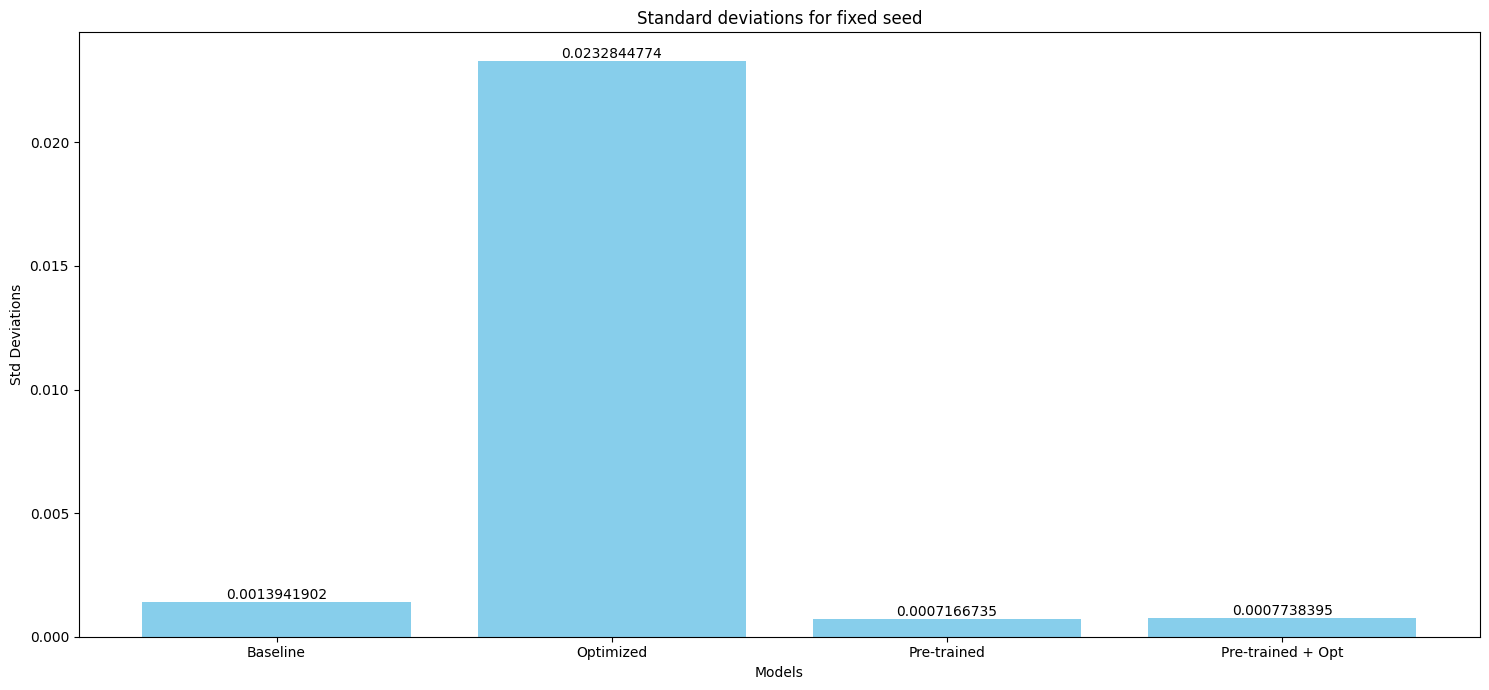

In [87]:
bar_graph_stats(models, stds_not_random, 'Standard deviations for fixed seed')

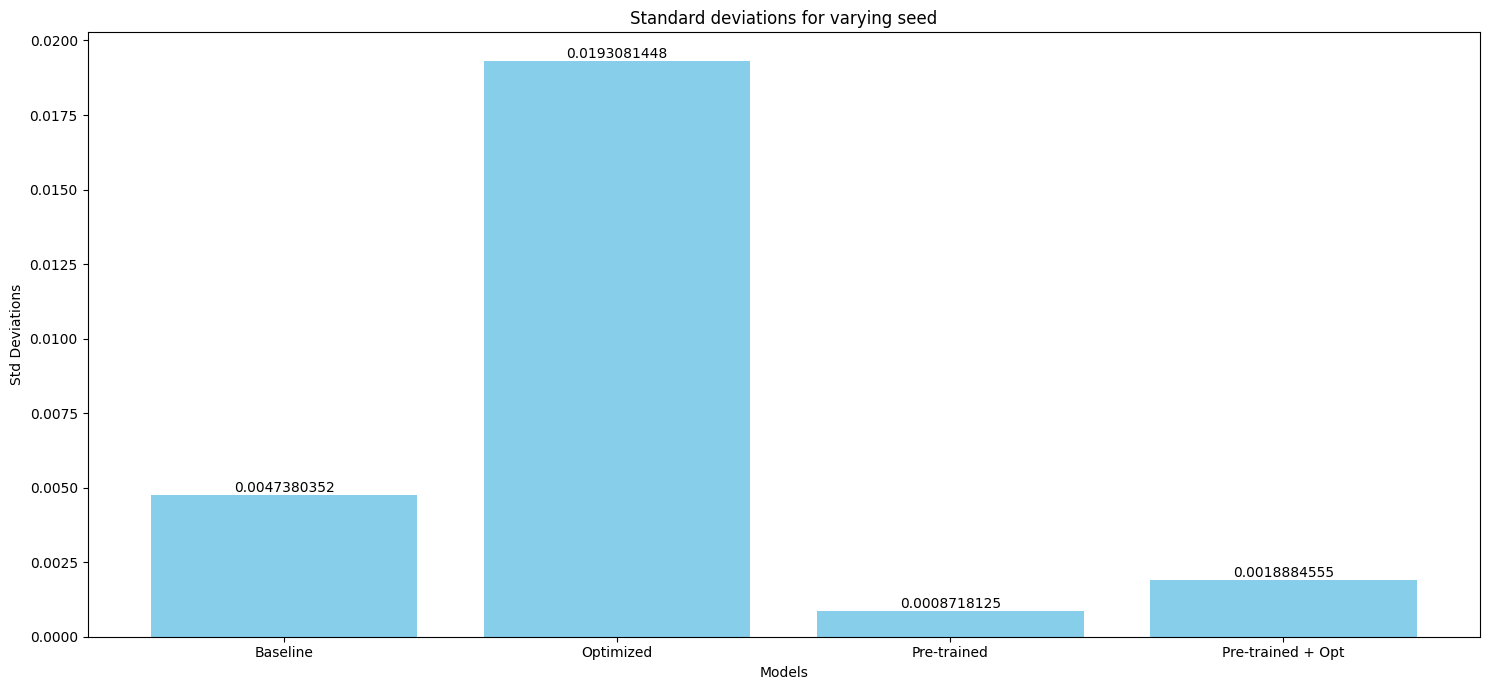

In [88]:
bar_graph_stats(models, stds_random, 'Standard deviations for varying seed')

Médias

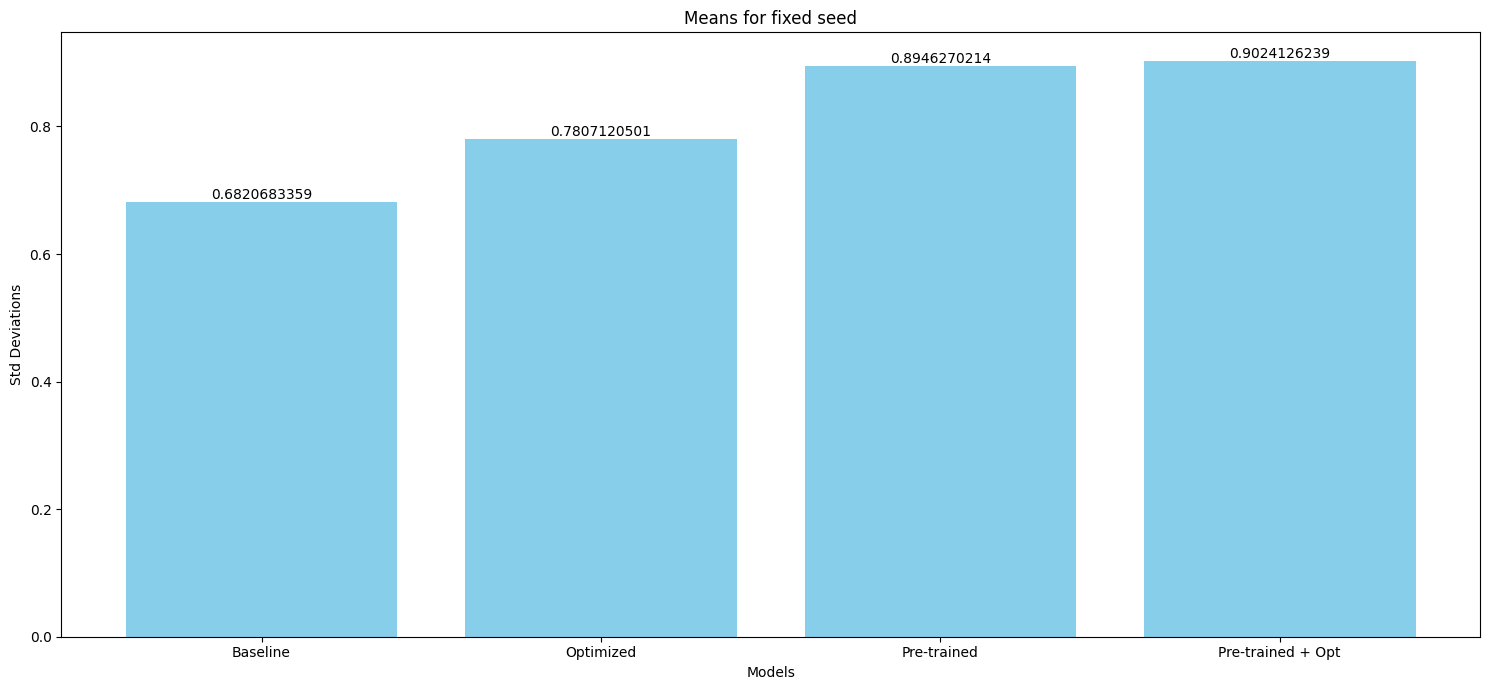

In [89]:
bar_graph_stats(models, means_not_random, 'Means for fixed seed')

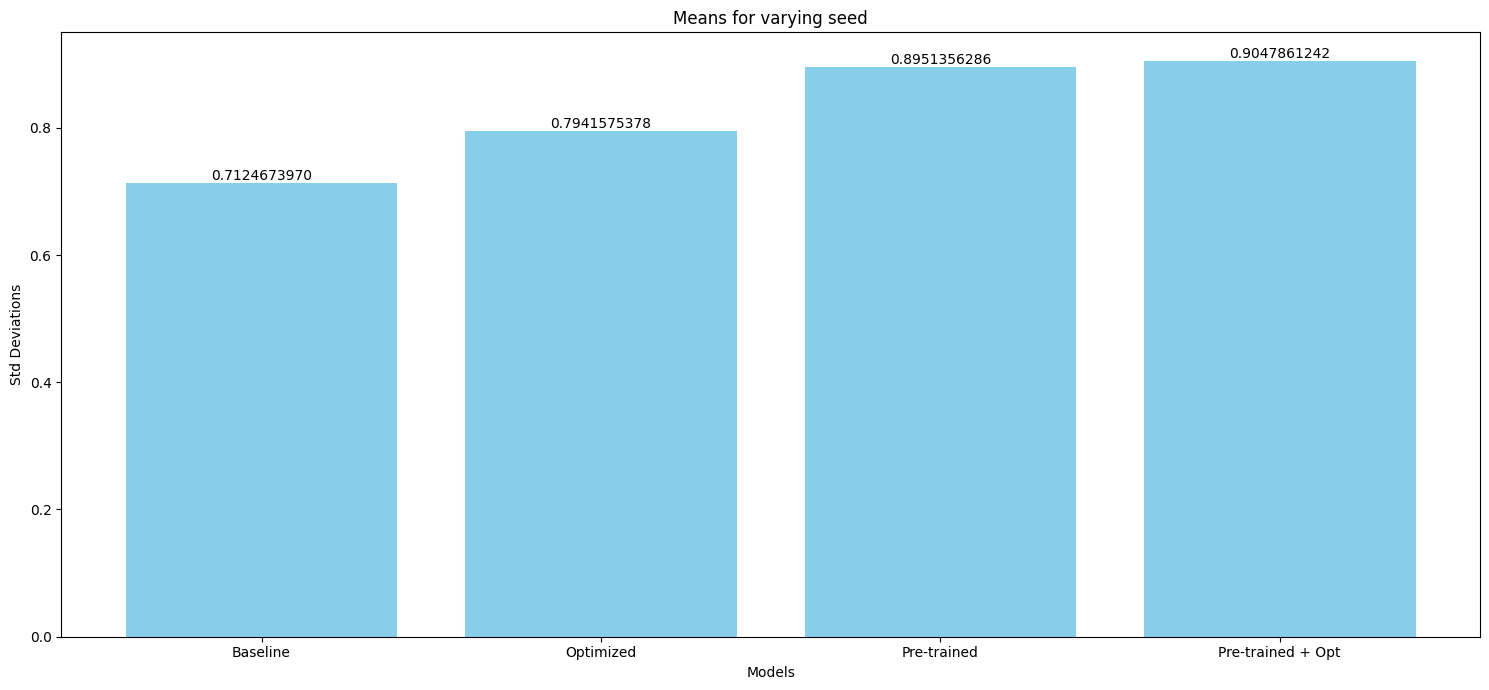

In [90]:
bar_graph_stats(models, means_random, 'Means for varying seed')

Métricas lado a lado

In [91]:
all_models = [
    'Baseline',
    'Baseline Varying',
    'Optimized',
    'Optimized Varying',
    'Pre-trained',
    'Pre-trained Varying',
    'Pre-trained + Opt',
    'Pre-trained + Opt Varying'
]

all_stddevs = []
for i in range(len(models)):
  all_stddevs.append(stds_not_random[i])
  all_stddevs.append(stds_random[i])

all_means = []
for i in range(len(models)):
  all_means.append(means_not_random[i])
  all_means.append(means_random[i])

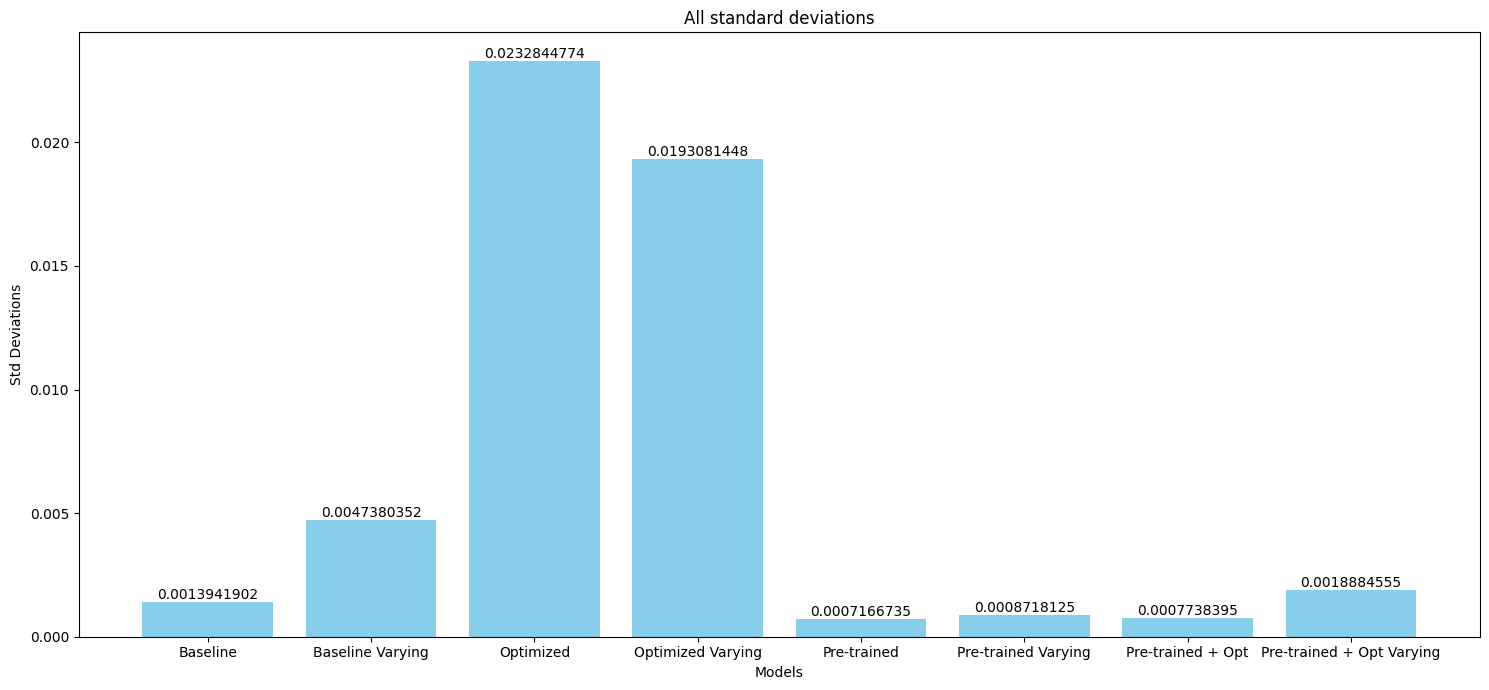

In [92]:
bar_graph_stats(all_models, all_stddevs, 'All standard deviations')

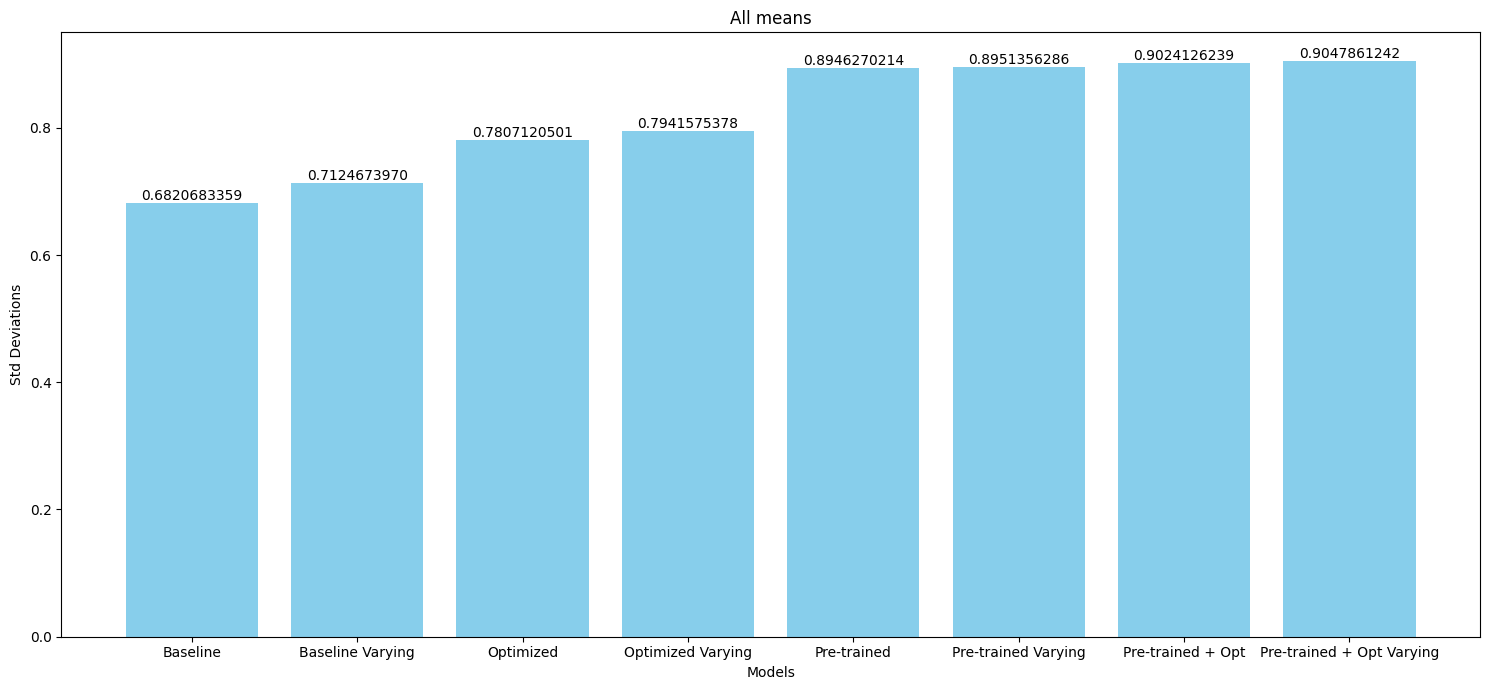

In [93]:
bar_graph_stats(all_models, all_means, 'All means')

Variar a seed aleatória faz com que as distribuições tenham diferenças estatisticamente significantes, além de aumentar todas as médias a custo de também aumentar o desvio padrão para quase todos os modelos, exceto o modelo otimizado (que tem um desvio padrão absurdamente maior de toda forma)

É interessante observar que o modelo com a maior acurácia tem um desvio padrão inclusive maior que o modelo com a pior acurácia, além de ser também maior que o modelo em segundo lugar, demonstrando que um ganho minúsculo na média das acurácias vem em troca de um aumento de mais ou menos 2x no desvio padrão, que pode ser interpretado como um "nível de certeza" nas classificações.